# Классификация заёмщиков

## Описание проекта
### Цель проекта

1. Решить задачу двухклассовой классификации, обучив модель на данных в `data.csv`. 
<br> После обучения мы должны получить вероятность принадлежности каждого объекта к таргет, равному единице 1

2. Сгруппировать выборку по значениям вероятности с шагом 0.1, и в каждой группе посчитать: сколько объектов в группе, сколько в группе объектов с target = 1.

3. Посчитать метрики модели (F-мера, ROC-AUC, коэффициент Джини и другие) на данных из `data.csv`.

4. С помощью полученной модели определить вероятность принадлежности к таргет 1 каждого объекта из `verify.csv`.

5. Записать полученные предсказания в csv-файл (разделитель – точка с запятой). 
<br> В файле должны быть два поля: `ID` – айди который задан в файле verify.csv и `score` – вероятность которую вы получили для данного ID.

Для решения задачи необходимо использовать логистическую регрессию.

Все данные анонимизированы.

### Исходные данные

Для разработки модели МО заказчик предоставил следующую информацию:


**`data.csv`**

Таблица содержит обучающию выборку.
- `ID` – уникальный айди записи;
- `feature_1` … `feature_124` – входные признаки;
- `target` - целевой признак.

**`verify.csv`**

Таблица содержит входные признаки, на основе которых нужно сделать предсказание. 
<br> Для данной таблицы необходимо предсказать вероятность принадлежности каждого объекта к таргет, равному единице 1.
- `ID` – уникальный айди записи;
- `feature_1` … `feature_124` – входные признаки.

### Этапы проекта

- Обзор данных.
- Исследовательский анализ данных.
- Предобработка данных (при необходимости)
- Обучение модели. Анализ результатов.
- Группировка выборки по значениям вероятности.
- Определение вероятности принадлежности к target = 1 каждого объекта из `verify.csv`.
- Запись полученых результатов в файл `predictions.csv`.
- Итоговые выводы.

## Обзор данных

### Подготовка библиотек

In [1]:
## Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

## Из библиотек импортируем необходимые функции и классы
from scipy import stats as st
from matplotlib.pyplot import figure
from math import sqrt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from scipy.stats import binom, norm
from phik.report import plot_correlation_matrix
from sklearn.base import BaseEstimator, TransformerMixin, clone 
from phik import phik_matrix

# Загружаем классы моделей
from sklearn.linear_model import LogisticRegression

# Загружаем метрики
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score, 
    precision_score,
    roc_auc_score,
    f1_score
)

# Загружаем класс для работы с пайплайнами
from sklearn.pipeline import Pipeline

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    StandardScaler, 
)    

# Загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

## Константы
RANDOM_STATE = 42  # константа для фиксации данных при обучении моделей, чтобы получать одинаковые результаты при пересчёте

# размер тестовой выборки
TEST_SIZE = 0.25

# Включение/отключение медленных операций, таких как построение корреляционной матрицы и т.п
FULL_CALC = True

### Создание датафреймов

Создадим датафреймы с названиями, как у исходных файлов.

In [2]:
data = pd.read_csv('data/data.csv', sep=';', index_col=0)
verify = pd.read_csv('data/verify.csv', sep=';', index_col=0)

### Датафрейм "data": обзор данных

In [3]:
def dataset_overview(df: pd.DataFrame, max_columns: int = 20):
    """
    Предоставляет обзор данных в заданном DataFrame.
    
    Параметры:
    df (pd.DataFrame): DataFrame для обзора.
    max_columns (int): Максимальное количество столбцов для вывода.
    
    Возвращает:
    None
    """
    pd.set_option('display.max_columns', max_columns)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)

    # Общая информация
    print("### Общая информация")
    print(df.info())
    print()

    # Первые несколько строк
    print("### Первые строки данных")
    print(tabulate(df.head().T, headers='keys', tablefmt='psql'))
    print()

    # Последние несколько строк
    print("### Последние строки данных")
    print(tabulate(df.tail().T, headers='keys', tablefmt='psql'))
    print()
    
    # Статистическое описание
    print("### Статистическое описание")
    print(tabulate(df.describe(include='all').T, headers='keys', tablefmt='psql'))
    print()

    # Проверка на пропущенные значения
    print("### Пропущенные значения")
    missing_values = df.isnull().sum()
    print(tabulate(missing_values[missing_values > 0].to_frame(), headers='keys', tablefmt='psql'))
    print()
    
    # Типы данных
    print("### Типы данных")
    print(tabulate(df.dtypes.to_frame('dtype'), headers='keys', tablefmt='psql'))
    print()
    
    # Уникальные значения
    print("### Уникальные значения в каждом столбце")
    unique_values = df.nunique()
    print(tabulate(unique_values.to_frame('unique'), headers='keys', tablefmt='psql'))
    print()
    
    # Распределение целевой переменной (если есть столбец target)
    if 'target' in df.columns:
        print("### Распределение целевой переменной")
        print(tabulate(df['target'].value_counts().to_frame('count'), headers='keys', tablefmt='psql'))

In [4]:
# выполним обзор данных датафрейма data
dataset_overview(data)

### Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 255820 entries, 1 to 255820
Columns: 125 entries, feature_1 to target
dtypes: float64(21), int64(104)
memory usage: 245.9 MB
None

### Первые строки данных
+-------------+---------------+---------------+---------------+---------------+---------------+
|             |             1 |             2 |             3 |             4 |             5 |
|-------------+---------------+---------------+---------------+---------------+---------------|
| feature_1   |     1         |     0         |     0         |     0         |     0         |
| feature_2   |     0         |     0         |     0         |     0         |     0         |
| feature_3   |     0         |     0         |     0         |     0         |     0         |
| feature_4   |  1381         |  1809         |  1804         |  1560         |   258         |
| feature_5   |    63         |    33         |    29         |    28         |    33         |
| fea

### Датафрейм "data": выводы

**Общие выводы:**

**1. Размер и структура данных:**
- Датасет содержит 255820 записей и 125 столбцов.
- Столбцы включают 21 столбец типа float64 и 104 столбцов типа int64.

**2. Распределение пропущенных значений:**
- Есть пять столбцов с пропущенными значениями: 
     - feature_102 (37795 пропущенных значений); 
     - feature_103 (37795);
     - feature_104 (37795);
     - feature_105 (37795);
     - feature_106 (41893);
<br> Остальные столбцы не имеют пропущенных значений.

**3. Описание и статистика отдельных столбцов:**
- Для числовых столбцов, таких как feature_4, среднее значение составляет 819.453, медианная отсечка — 562, стандартное отклонение — 772.967.
- Некоторые числовые столбцы имеют достаточно широкий диапазон значений (например, feature_50 с максимальным значением в 2.5 млн.).
- Функции с меньшим числом уникальных значений, таких как бинарные feature_1, feature_2, и другие, могут представлять категории или флаги.

**4. Уникальные значения:**
- Большое количество столбцов имеют только два уникальных значения, что указывает на бинарные или категориальные признаки.
- Некоторые столбцы имеют большое количество уникальных значений (например, feature_105 с 2294 уникальными значениями).

**5. Распределение целевой переменной:**
- 0 класс: 205310 записей (80.3%)
- 1 класс: 50510 записей (19.7%)
<br> Налицо дисбаланс классов, что может оказывать влияние на модели машинного обучения.

**Выводы по обработке данных:**

- **Обработка пропущенных значений:**
<br> Обработку пропущенных значений для feature_102, feature_103, feature_104, feature_105, и feature_106 будем производить в пайплайне, заполним пропуски медианой с помощью SimpleImputer.

- **Анализ дисбаланса классов:** 
<br> Поскольку целевая переменная несбалансирована, применим автоматическую корректировку весов при обучении в настройках модели LogisticRegression.

- **Выявление важнейших признаков:** 
<br> Путем вычисления кореляции между признаками и целевой переменной необходимо выявить важнейшие признаки и устраненить менее значимые для уменьшения размерности. На первом этапе удалим коррелированные признаки после корреляционного анализа.

- **Нормализация данных:**
<br> Поскольку некоторые числовые значения варьируются в большом диапазоне, нормализация или стандартизация может помочь улучшить производительность моделей. Для логистической регрессии будем использовать стандартизацию данных, так как модель чувствительна к масштабу признаков. Применим StandardScaler на этапе подготовки признаков.

### Датафрейм "verify": обзор данных 

In [5]:
# выполним обзор данных датафрейма data
dataset_overview(verify)

### Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56030 entries, 255821 to 311850
Columns: 124 entries, feature_1 to feature_124
dtypes: float64(21), int64(103)
memory usage: 53.4 MB
None

### Первые строки данных
+-------------+---------------+--------------+--------------+---------------+---------------+
|             |        255821 |       255822 |       255823 |        255824 |        255825 |
|-------------+---------------+--------------+--------------+---------------+---------------|
| feature_1   |     0         |     0        |     0        |     1         |     0         |
| feature_2   |     0         |     0        |     0        |     0         |     0         |
| feature_3   |     0         |     0        |     0        |     0         |     0         |
| feature_4   |  2268         |    42        |   265        |   834         |   772         |
| feature_5   |    34         |    49        |    69        |    25         |    26         |
| feature_6  

### Датафрейм "verify": выводы

**Выводы на основе данных:**

**1. Структура данных**:
   - Датасет содержит 56030 записей и 124 столбца.
   - Присутствуют числовые признаки типов `float64` и `int64`.

**2. Количественная характеристика данных**:
   - В датасете много бинарных переменных (принимающих значение 0 или 1).
   - Числовые признаки имеют широкий диапазон значений.

**3. Наличие пропущенных значений**:
   - Пропущенные значения есть в 5 столбцах:
   - `feature_102` - 11459 пропущенных значений
   - `feature_103` - 11459 пропущенных значений
   - `feature_104` - 11459 пропущенных значений
   - `feature_105` - 11459 пропущенных значений
   - `feature_106` - 12960 пропущенных значений (наибольшее значение, около 23%)

**4. Статистическое описание числовых данных**:
   - Признаки имеют разный диапазон значений, некоторые из которых могут быть сильными выбросами (например, `feature_53` с максимальным значением `7405.78`).

**5. Уникальные значения в столбцах**:
   - Большое количество столбцов имеют только два уникальных значения, что указывает на их бинарный характер.
   - Признаки с большим количеством уникальных значений могут требовать специальной обработки.

<br> **Выводы по обработке данных:**

- Произведем аналогичную обработку данных, как для датафрейма `data`.

## Исследовательский анализ данных датафрейма "data"

1. Выполним поиск дубликатов.
2. Исследуем выбросы.
<br> Для нахождения выбросов используем межквартильный размах, поскольку по умолчанию предполагаем, что распределение данных может быть далеко от нормального.

### Поиск дубликатов

In [6]:
data.duplicated().sum()

0

Дубликатов не обнаружено.

### Кореляционный анализ

Построим матрицу корреляции признаков с помощью библиотеки `phik`.

In [7]:
def plot_phik_correlation_matrix(df, threshold=20, corr_threshold=0.9, figsize=(12, 10), color_map='coolwarm', fontsize_factor=1.2, show_labels=True):
    """
    Строим матрицу корреляций с использованием библиотеки phik для заданного DataFrame и возвращаем пары, где корреляция выше заданного порога.

    df: DataFrame для расчета корреляционной матрицы.
    threshold: Порог для уникальных значений, при превышении которого столбец считается непрерывным. По умолчанию 20.
    corr_threshold: Порог для корреляции, выше которого пары считаются высоко коррелированными. По умолчанию 0.9.
    figsize: Размер фигуры для графика. По умолчанию (12, 10).
    color_map: Цветовая схема для тепловой карты. По умолчанию 'coolwarm'.
    fontsize_factor: Коэффициент для изменения размера шрифта. По умолчанию 1.2.
    show_labels: Логический параметр для включения или отключения меток на осях. По умолчанию True.
    """

    # Определяем непрерывные величины
    interval_cols = [col for col in df.columns if df[col].nunique() > threshold]

    # Считаем корреляции
    phik_overview = phik_matrix(df=df, interval_cols=interval_cols)

    # Найдём пары, где корреляция больше заданного порога
    high_corr_pairs = []
    for i in range(len(phik_overview.columns)):
        for j in range(i + 1, len(phik_overview.columns)):
            if phik_overview.iloc[i, j] > corr_threshold:
                high_corr_pairs.append((phik_overview.columns[i], phik_overview.columns[j], phik_overview.iloc[i, j]))

    # Строим матрицу
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(phik_overview.values, cmap=color_map, vmin=0, vmax=1)
    fig.colorbar(cax)

    ax.set_title(f'Матрица корреляций\ncorrelation $\phi_K$', pad=20, fontsize=fontsize_factor * 10)

    if show_labels:
        # Устанавливаем метки на осях
        ax.set_xticks(np.arange(len(phik_overview.columns)))
        ax.set_yticks(np.arange(len(phik_overview.index)))
        ax.set_xticklabels(phik_overview.columns, rotation=90, fontsize=fontsize_factor * 8)
        ax.set_yticklabels(phik_overview.index, fontsize=fontsize_factor * 8)
    else:
        # Отключаем метки на осях
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    return high_corr_pairs

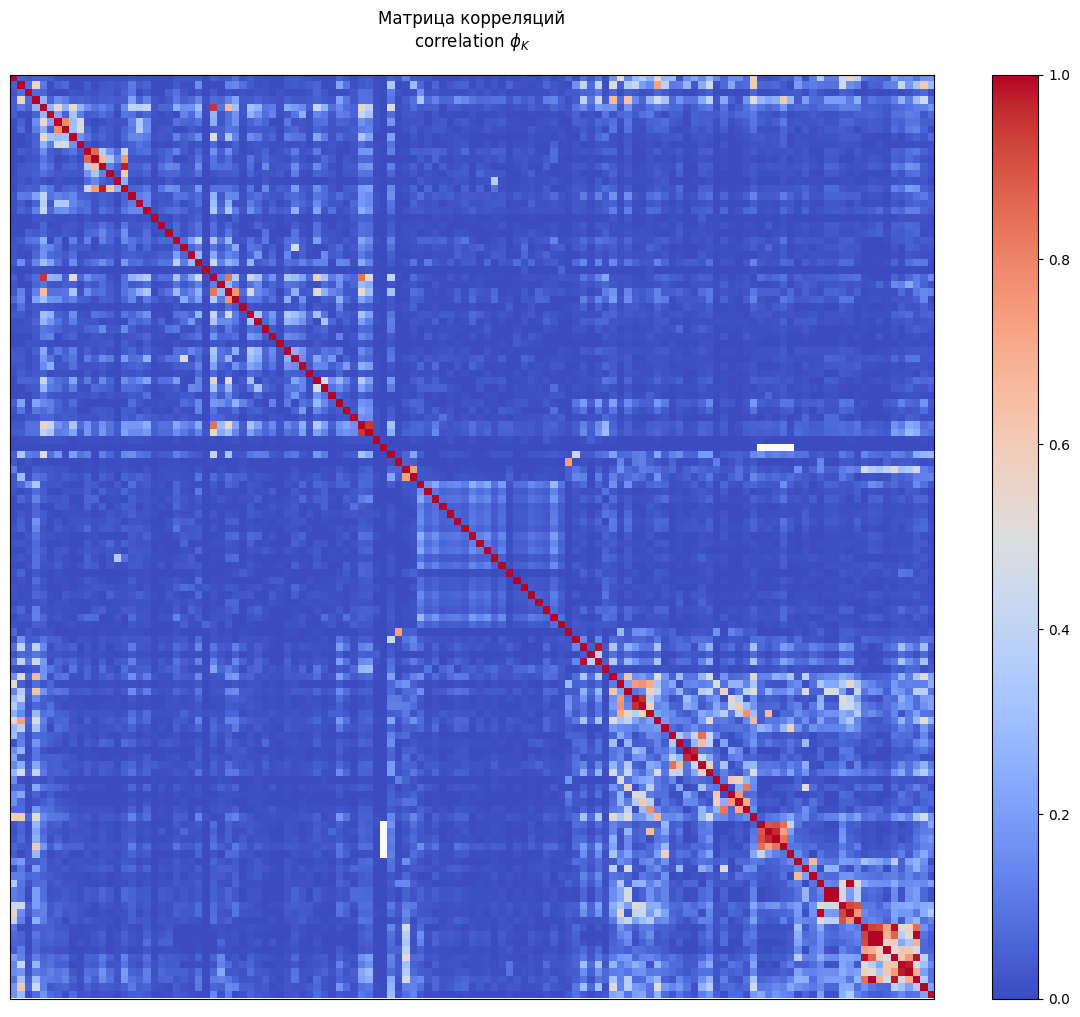

In [8]:
# Построим корреляционную матрицу и выведем пары коррелированных признаков
if FULL_CALC:
    high_corr_pairs = plot_phik_correlation_matrix(df=data, figsize=(15, 12), show_labels=False)

In [9]:
# выведем пары признаков с высокой корреляцией
print('Количество коррелированных пар:', len(high_corr_pairs))
high_corr_pairs

Количество коррелированных пар: 18


[('feature_5', 'feature_28', 0.9458994188185063),
 ('feature_13', 'feature_16', 0.9751239007566738),
 ('feature_48', 'feature_49', 0.9427783977413994),
 ('feature_78', 'feature_80', 0.98756325337678),
 ('feature_85', 'feature_86', 0.954290558411007),
 ('feature_92', 'feature_93', 0.9669391829064998),
 ('feature_102', 'feature_104', 0.9031214222841621),
 ('feature_103', 'feature_104', 0.9619031462639591),
 ('feature_110', 'feature_114', 1.0),
 ('feature_111', 'feature_112', 0.9999913471182257),
 ('feature_113', 'feature_114', 0.9199767353682272),
 ('feature_116', 'feature_117', 0.9272440269577344),
 ('feature_116', 'feature_118', 0.9128019536990474),
 ('feature_116', 'feature_120', 0.9909351352946695),
 ('feature_117', 'feature_118', 1.0),
 ('feature_117', 'feature_123', 0.9970999695967516),
 ('feature_120', 'feature_123', 0.9835503373807412),
 ('feature_121', 'feature_122', 0.9781333372816265)]

**Итог:**

Корреляционная матрица в целом выглядит неплохо, но есть признаки с высокой корреляцией (выше 0,9). 
<br> Удалим коррелированные признаки: из пары оставим только тот, где меньше пропусков либо меньше выбросов, если пропусков нет или их количество одинаково.

### Удаление коррелированных признаков

In [10]:
# Создам функцию, которая вычисляет процент выбросов по каждому столбцу DataFrame. 
# Будем использовать метод межквартильного размаха (IQR) для определения выбросов.
def calculate_outliers_percentage(df):
    outliers_percentage = {}
    
    for column in df.select_dtypes(include=[np.number]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_count = outliers[column].count()
        total_count = df[column].count()
        outliers_percentage[column] = (outliers_count / total_count) * 100
    
    return outliers_percentage

In [11]:
def remove_correlated_features(df, threshold=0.9):
    """
    Удаляет коррелированные признаки из DataFrame, оставляя те, где меньше пропусков или выбросов.

    df: Исходный DataFrame.
    threshold: Порог абсолютного значения корреляции для удаления признаков. По умолчанию 0.9.
    DataFrame с удаленными коррелированными признаками.
    """
    
    # Определяем непрерывные величины
    interval_cols = [col for col in df.columns if df[col].nunique() > 20]

    # Считаем корреляции
    phik_overview = phik_matrix(df=df, interval_cols=interval_cols)

    # Создаем список для хранения удаляемых столбцов
    columns_to_drop = set()

    # Считаем процент выбросов для каждого числового столбца
    outliers_percentage = calculate_outliers_percentage(df)

    # Проходим по корреляционной матрице и удаляем высококоррелированные признаки
    for i in range(len(phik_overview.columns)):
        for j in range(i + 1, len(phik_overview.columns)):
            if abs(phik_overview.iloc[i, j]) > threshold:
                col1, col2 = phik_overview.columns[i], phik_overview.columns[j]
                # Проверяем количество пропусков
                null_counts = df[[col1, col2]].isnull().sum()
                
                if null_counts[col1] < null_counts[col2]:
                    columns_to_drop.add(col2)
                elif null_counts[col1] > null_counts[col2]:
                    columns_to_drop.add(col1)
                else:
                    if outliers_percentage.get(col1, 0) < outliers_percentage.get(col2, 0):
                        columns_to_drop.add(col2)
                    else:
                        columns_to_drop.add(col1)

    # Удаляем столбцы из DataFrame
    df_reduced = df.drop(columns=columns_to_drop)
    
    return df_reduced

In [12]:
# Создадим датафрейм с меньшим количеством признаков, удалив кореллированные
data_reduced = remove_correlated_features(data)

In [13]:
# Получение списка удаленных столбцов
removed_columns = list(set(data.columns) - set(data_reduced.columns))
print(f"Удаленные столбцы: {len(removed_columns)} шт", removed_columns)

Удаленные столбцы: 15 шт ['feature_93', 'feature_121', 'feature_120', 'feature_16', 'feature_117', 'feature_103', 'feature_111', 'feature_80', 'feature_110', 'feature_118', 'feature_28', 'feature_48', 'feature_85', 'feature_102', 'feature_113']


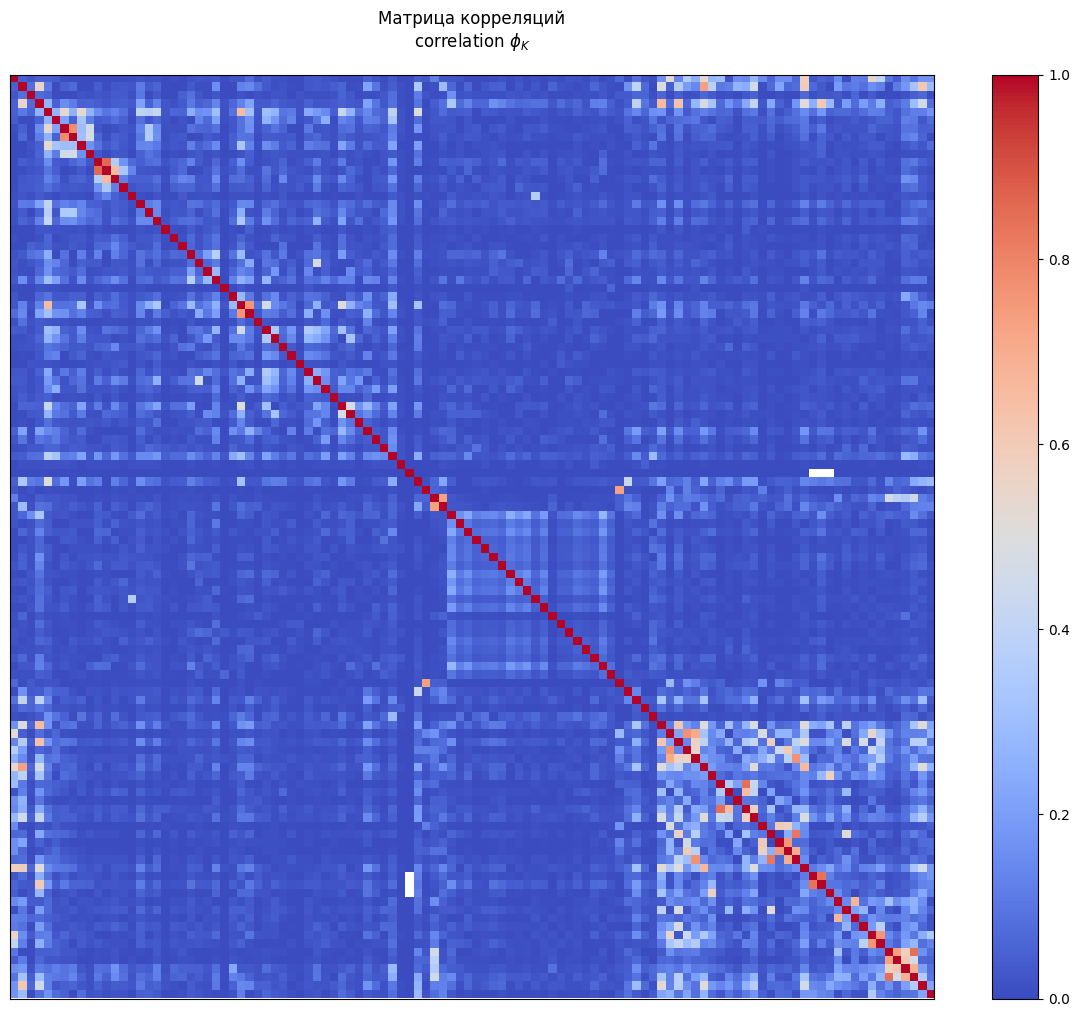

In [14]:
# Построим корреляционную матрицу для датафрейма с уменьшенным количеством признаков data_reduced
if FULL_CALC:
    high_corr_pairs = plot_phik_correlation_matrix(df=data_reduced, figsize=(15, 12), show_labels=False)

In [15]:
# выведем пары признаков с высокой корреляцией
print('Количество коррелированных пар:', len(high_corr_pairs))
high_corr_pairs

Количество коррелированных пар: 0


[]

Функция выдала пустой список, это значит в корреляционной матрице нет признаков с корреляцией более 0,9.

In [16]:
# выведем размеры нового датафрейма
data_reduced.shape

(255820, 110)

**Итог:**

Коррелированные признаки удалены. Данные готовы для дальнейшей обработки.
<br> Важно удалить коррелированные признаки (removed_columns) из датафрейма verify перед применением модели для предсказаний.

### Исследование выбросов

Создадим список категориальных признаков (в т.ч. бинарных), а затем исключим их из анализа выбросов.

In [17]:
# Выявление бинарных признаков
binary_features = [col for col in data_reduced.columns if sorted(data[col].unique()) == [0, 1]]
print('Бинарные признаки:', len(binary_features))

Бинарные признаки: 71


In [18]:
# Выявление категориальных признаков
threshold = 20  # Например, если уникальных значений меньше 20, считаем признак категориальным

# Выявление категориальных признаков
categorical_features = [col for col in data_reduced.drop(columns=binary_features).columns if data_reduced[col].nunique() < threshold]

print(f"Категориальные признаки: {len(categorical_features)}")
print(categorical_features)

Категориальные признаки: 2
['feature_18', 'feature_92']


In [19]:
# Создадим список соличественных признаков
quantitative_columns = list(set(data_reduced.columns) - set(categorical_features) - set(binary_features))

print('Количественные признаки:', len(quantitative_columns))

Количественные признаки: 37


In [20]:
# Создадим словарь, где будем хранить процент выбросов по каждому признаку, кроме категориальных и бинарных
outliers_percentage = calculate_outliers_percentage(data_reduced[quantitative_columns])

# Фильтрация значений словаря с процентом выбросов более 10%
filtered_outliers_percentage = {feature: percentage for feature, percentage in outliers_percentage.items() if percentage > 10}

# Вывод отфильтрованных значений
print(f"Процент выбросов")
for feature, percentage in filtered_outliers_percentage.items():
    print(f'{feature}: {percentage:.2f}%')

Процент выбросов
feature_108: 12.73%
feature_54: 12.51%
feature_83: 10.51%
feature_112: 22.77%
feature_104: 10.56%
feature_96: 22.30%
feature_99: 19.75%
feature_47: 10.03%
feature_109: 12.14%
feature_90: 24.68%


In [21]:
# функция для построения гистограммы, боксплота и вывода описательных статистик
def plot_hist_boxplot(df, column, title, xlabel):

    #np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    fig, axes = plt.subplots(2, 1, figsize=(10, 5))

    axes[0].hist(df[column], bins = 50, alpha = 1)
    axes[0].grid()
    plt.xlabel(xlabel)

    df.boxplot(column, ax = axes[1], vert = False)
    fig.suptitle(title)

    plt.show()
    
    # выведем основные описательные статистики
    print(df[column].describe())
    print()
    
    # выведем количество уникальных значений
    print(f'Уникальных значений: {df[column].nunique()}')
    
    # Проверка и вывод процента выбросов
    if column in filtered_outliers_percentage:
        print(f'Выбросы: {filtered_outliers_percentage[column].round(2)}%')
    else:
        print('Выбросы: отсутствуют')

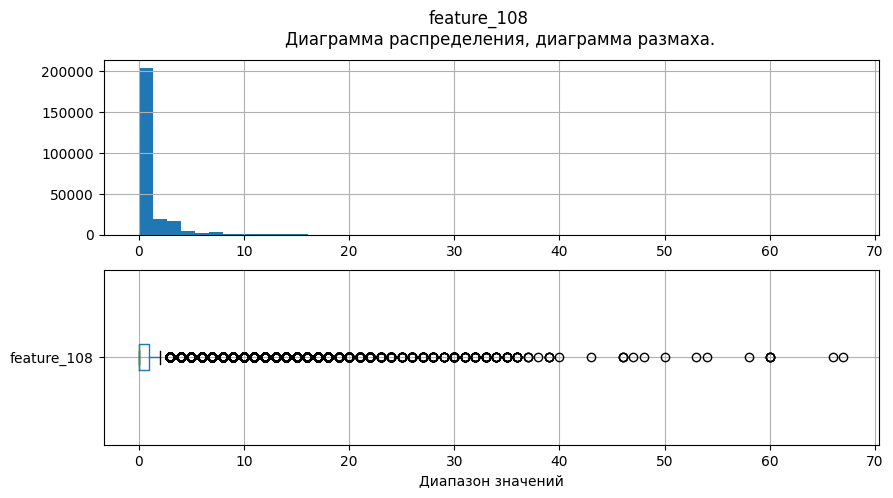

count    255820.000000
mean          1.055602
std           2.474374
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          67.000000
Name: feature_108, dtype: float64

Уникальных значений: 52
Выбросы: 12.73%


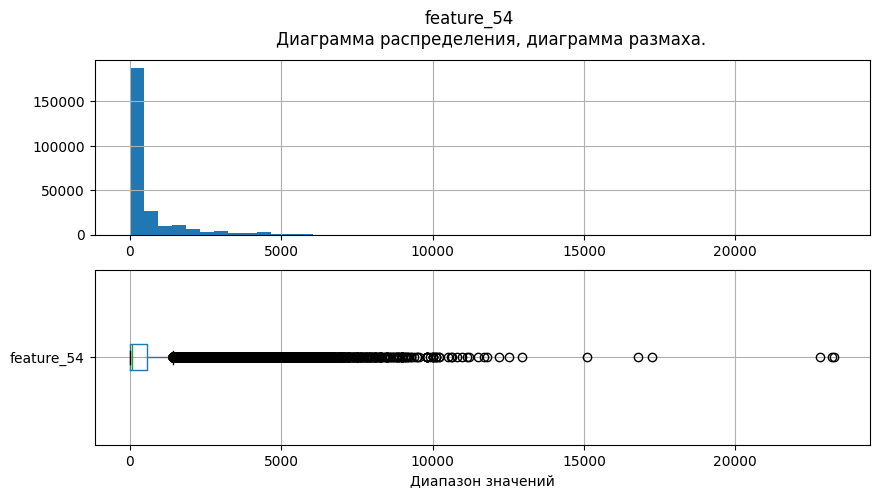

count    255820.000000
mean        516.821102
std         968.218907
min           0.000000
25%           0.000000
50%          60.000000
75%         570.000000
max       23272.850000
Name: feature_54, dtype: float64

Уникальных значений: 1010
Выбросы: 12.51%


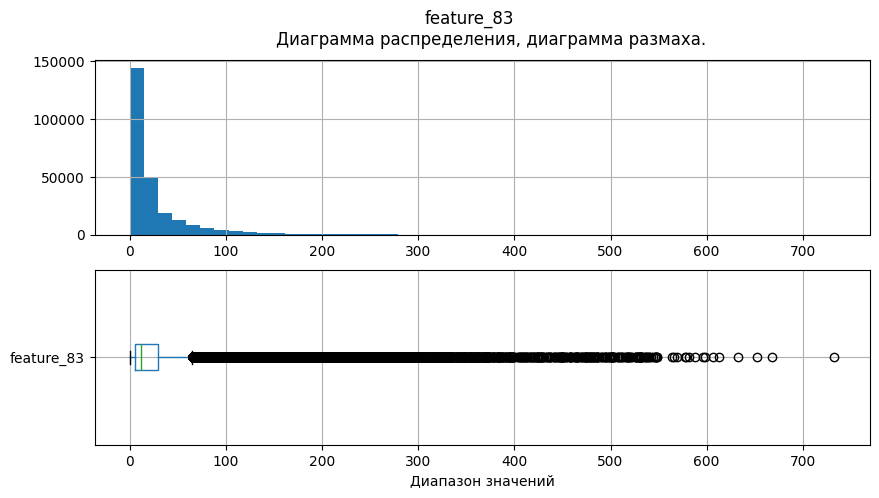

count    255820.000000
mean         26.475092
std          41.360118
min           0.000000
25%           5.000000
50%          12.000000
75%          29.000000
max         733.000000
Name: feature_83, dtype: float64

Уникальных значений: 529
Выбросы: 10.51%


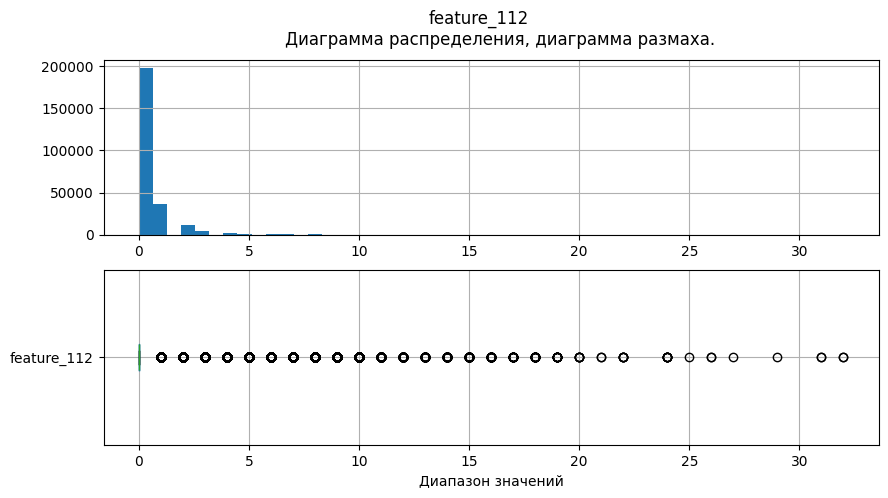

count    255820.000000
mean          0.432582
std           1.191449
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.000000
Name: feature_112, dtype: float64

Уникальных значений: 30
Выбросы: 22.77%


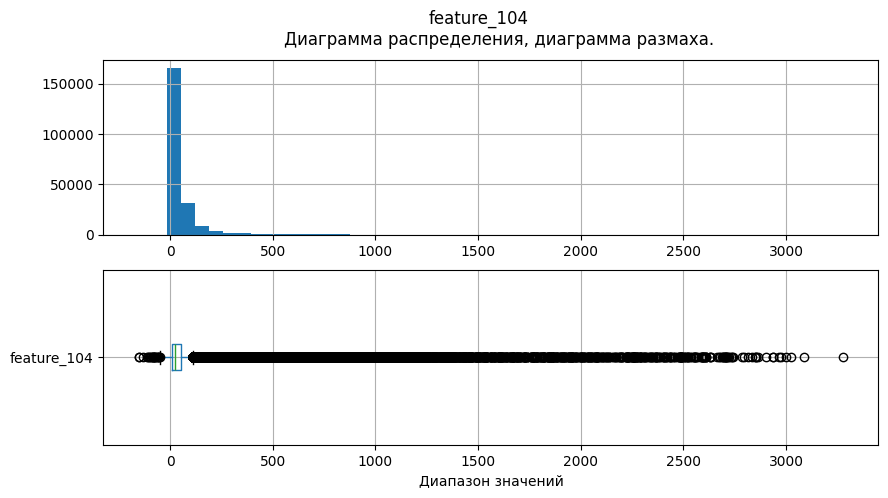

count    218025.000000
mean         59.184222
std         147.625042
min        -153.000000
25%          11.000000
50%          23.000000
75%          51.000000
max        3278.000000
Name: feature_104, dtype: float64

Уникальных значений: 1794
Выбросы: 10.56%


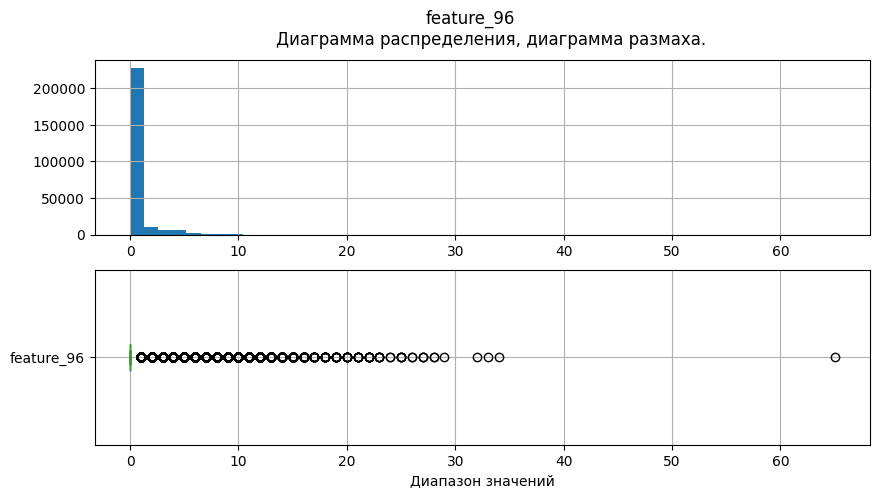

count    255820.000000
mean          0.546709
std           1.508560
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          65.000000
Name: feature_96, dtype: float64

Уникальных значений: 34
Выбросы: 22.3%


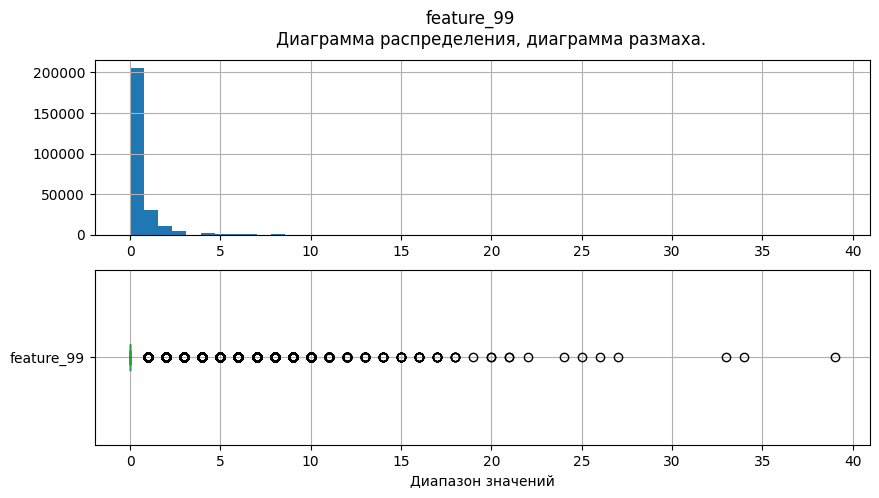

count    255820.000000
mean          0.376401
std           1.055833
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: feature_99, dtype: float64

Уникальных значений: 30
Выбросы: 19.75%


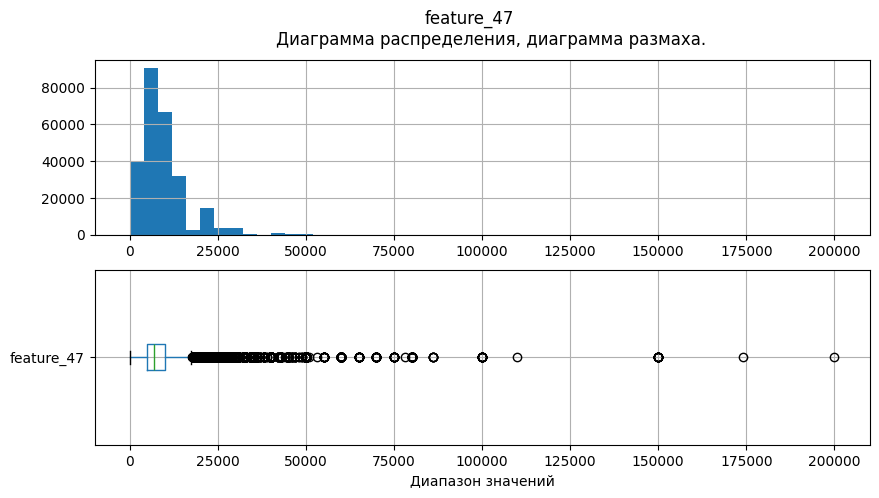

count    255820.000000
mean       9128.381995
std        6889.862296
min           0.000000
25%        5000.000000
50%        7000.000000
75%       10000.000000
max      200000.000000
Name: feature_47, dtype: float64

Уникальных значений: 278
Выбросы: 10.03%


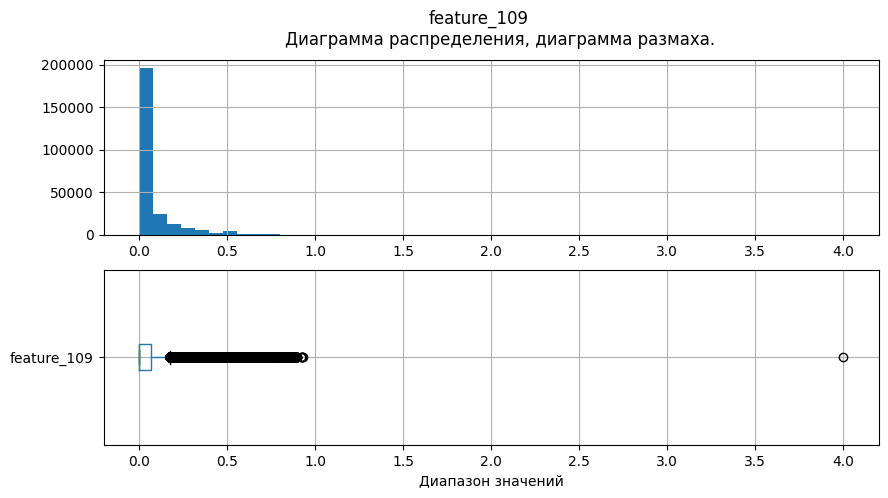

count    255820.000000
mean          0.061278
std           0.123229
min           0.000000
25%           0.000000
50%           0.000000
75%           0.071429
max           4.000000
Name: feature_109, dtype: float64

Уникальных значений: 1227
Выбросы: 12.14%


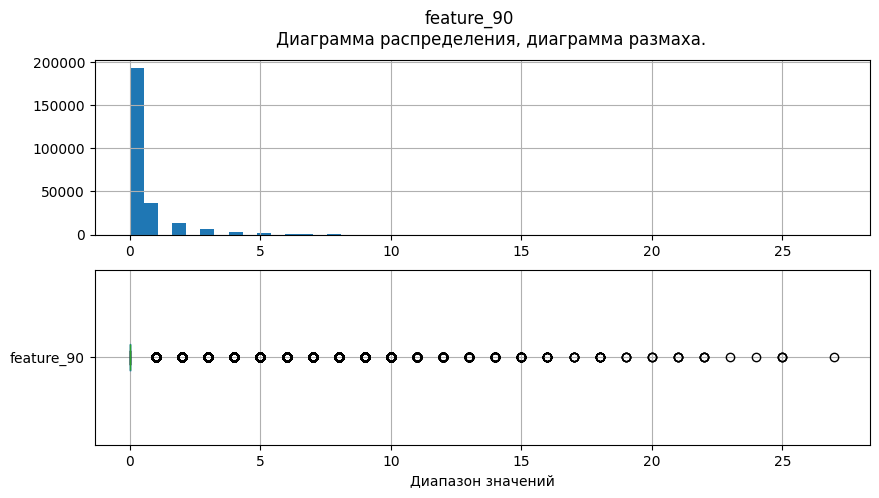

count    255820.000000
mean          0.485662
std           1.204242
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          27.000000
Name: feature_90, dtype: float64

Уникальных значений: 27
Выбросы: 24.68%


In [22]:
if FULL_CALC:
    for key in filtered_outliers_percentage:
        # строим график для каждого признака, где более 10% выбросов
        plot_hist_boxplot(df=data_reduced, 
                          column=key,
                          title=f'{key}\n\
        Диаграмма распределения, диаграмма размаха.',
                          xlabel='Диапазон значений')

**Вывод:**

При предварительном анализе данных в нескольких признаках была замечена значительная доля выбросов. Вот основные моменты:

- Наблюдаемая выборка содержит до 24% выбросов в различных признаках, что указывает на наличие экстремальных значений, которые могут искажать статистические характеристики модели.

- Признак feature_96 имеет наибольшую долю выбросов (22.3%). Значения в этом признаке в основном равны нулю, однако присутствуют и значительные отклонения, достигающие 65.

- Признак feature_104 с максимумом 3278 и значительным стандартным отклонением указывает на высокую изменчивость, что также подтверждает наличие выбросов.

- Признаки, такие как feature_83 и feature_47, имеют выбросы около 10.51% и 10.03%, соответственно, что может указывать на влияние крайних значений на среднее и стандартное отклонение.

- Количество уникальных значений варьируется от 30 до 1794. В некоторых признаках, таких как feature_112, большая часть значений относится к нулю, что делает их восприимчивыми к выбросам.

Перед дальнейшим анализом и моделированием необходимо провести обработку выбросов для уменьшения их влияния на результаты. Проведение такой предобработки поможет улучшить качество и точность моделей, которые будут использоваться в дальнейшем.

### Каппирование выбросов

На начальном этапе каппируем выбросы, это позволит сохранить данные и уловить некоторые закономерности в процессе обучения. Далее можно применить удаление или более сложные техники обработки выбросов.

In [23]:
# Функция для каппирования выбросов

def winsorize(df, columns):
    """
    Все значения в df[column], которые меньше lower_bound, будут заменены на lower_bound.
    Все значения, превышающие upper_bound, будут заменены на `upper_bound.
    Значения, находящиеся в пределах [lower_bound, upper_bound], останутся неизменными.
    """
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Каппирование значений
        df[column] = np.clip(df[column], lower_bound, upper_bound)
        
    return df

In [24]:
# каппируем выбросы во всех столбцах quantitative_columns
data_reduced = winsorize(data_reduced, quantitative_columns)

In [25]:
# Выведем первые строки датафрейма после каппирования
data_reduced.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_109,feature_112,feature_114,feature_115,feature_116,feature_119,feature_122,feature_123,feature_124,target
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1381,63,0,0,1,0,0,...,0.178571,0,0,0,0,0.0,7526.3157,12000,0.583333,0
2,0,0,0,1809,33,1,0,1,0,0,...,0.081967,0,0,0,0,0.0,8393.4426,30000,0.333333,0
3,0,0,0,1804,29,0,1,0,0,0,...,0.055556,0,0,1,0,0.0,3425.9259,15000,0.200000,0
4,0,0,0,1560,28,1,1,0,0,0,...,0.000000,0,0,0,0,0.0,1946.6666,3000,0.666667,0
5,0,0,0,258,33,1,0,0,0,1,...,0.000000,0,0,0,0,0.0,4444.4444,8000,0.250000,0


In [26]:
# выведем общую информацию
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255820 entries, 1 to 255820
Columns: 110 entries, feature_1 to target
dtypes: float64(22), int64(88)
memory usage: 216.6 MB


In [27]:
# Создадим словарь, где будем хранить процент выбросов по каждому признаку, кроме категориальных и бинарных
outliers_percentage = calculate_outliers_percentage(data_reduced[quantitative_columns])
print('Процент выбросов')
outliers_percentage

Процент выбросов


{'feature_123': 0.0,
 'feature_108': 0.0,
 'feature_84': 0.0,
 'feature_95': 0.0,
 'feature_54': 0.0,
 'feature_50': 0.0,
 'feature_97': 0.0,
 'feature_83': 0.0,
 'feature_5': 0.0,
 'feature_86': 0.0,
 'feature_88': 0.0,
 'feature_19': 0.0,
 'feature_87': 0.0,
 'feature_112': 0.0,
 'feature_49': 0.0,
 'feature_53': 0.0,
 'feature_119': 0.0,
 'feature_91': 0.0,
 'feature_4': 0.0,
 'feature_98': 0.0,
 'feature_104': 0.0,
 'feature_124': 0.0,
 'feature_94': 0.0,
 'feature_96': 0.0,
 'feature_100': 0.0,
 'feature_82': 0.0,
 'feature_101': 0.0,
 'feature_122': 0.0,
 'feature_106': 0.0,
 'feature_99': 0.0,
 'feature_47': 0.0,
 'feature_109': 0.0,
 'feature_90': 0.0,
 'feature_105': 0.0,
 'feature_17': 0.0,
 'feature_89': 0.0,
 'feature_55': 0.0}

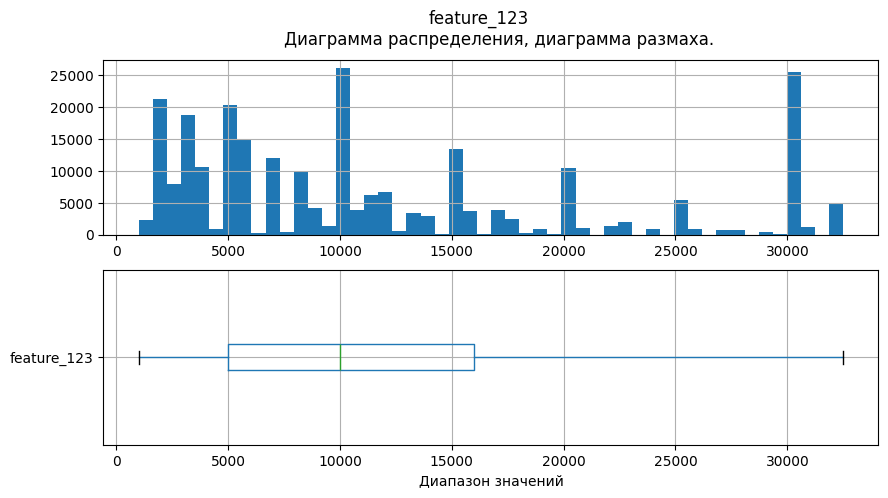

count    255820.000000
mean      11869.666082
std        9200.903860
min        1000.000000
25%        5000.000000
50%       10000.000000
75%       16000.000000
max       32500.000000
Name: feature_123, dtype: float64

Уникальных значений: 313
Выбросы: отсутствуют


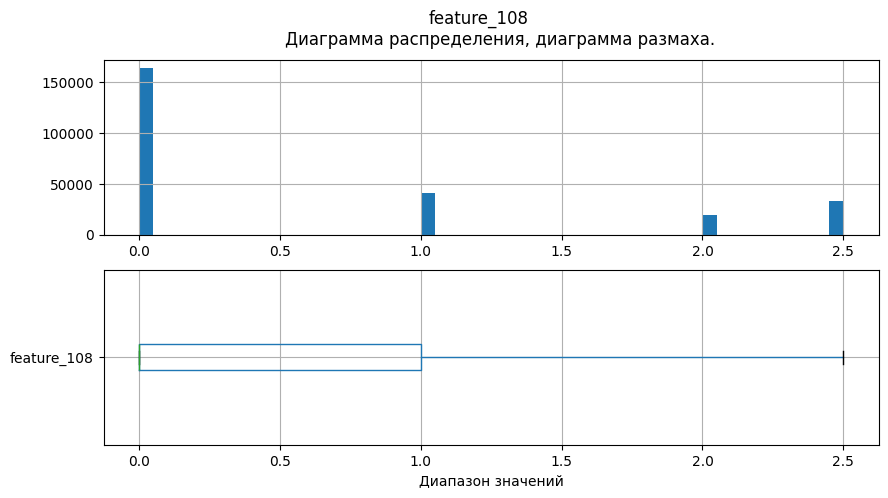

count    255820.000000
mean          0.626697
std           0.927549
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           2.500000
Name: feature_108, dtype: float64

Уникальных значений: 4
Выбросы: 12.73%


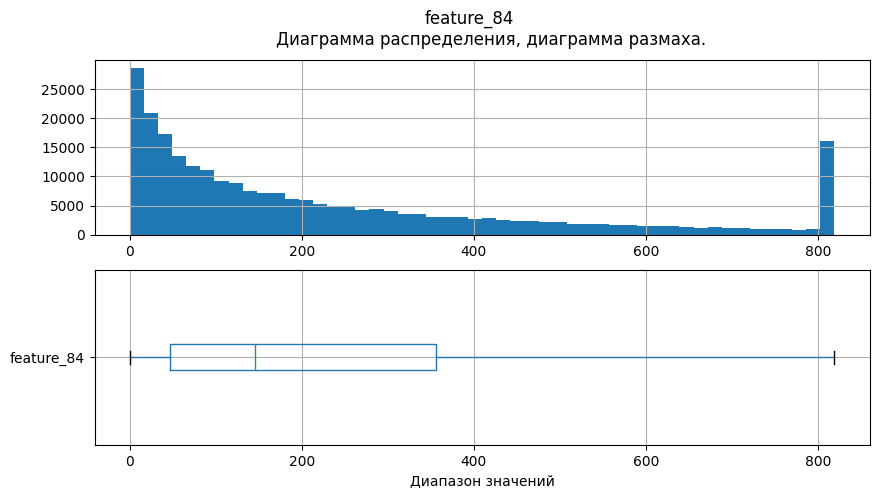

count    255820.000000
mean        237.614088
std         241.947851
min           0.000000
25%          47.000000
50%         146.000000
75%         356.000000
max         819.500000
Name: feature_84, dtype: float64

Уникальных значений: 821
Выбросы: отсутствуют


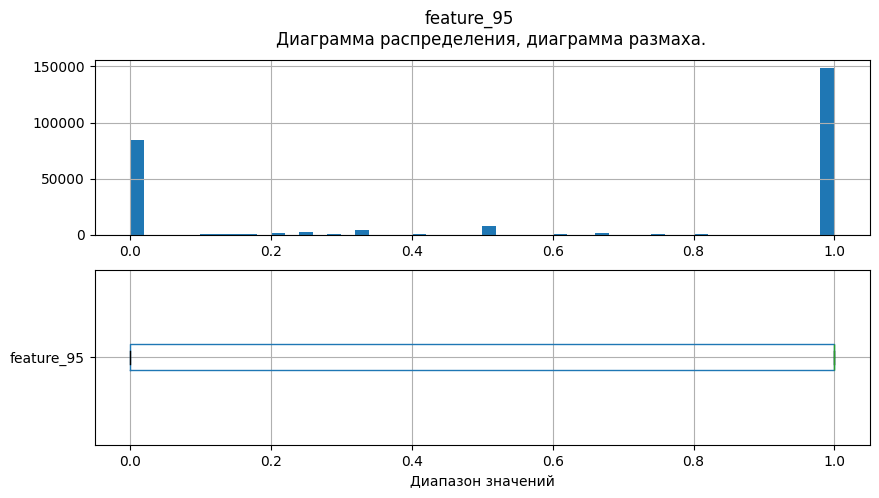

count    255820.000000
mean          0.618092
std           0.466044
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: feature_95, dtype: float64

Уникальных значений: 116
Выбросы: отсутствуют


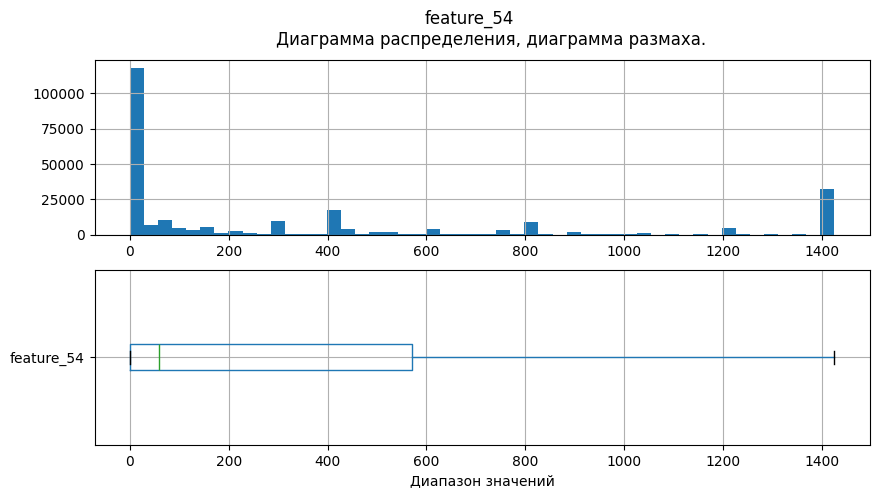

count    255820.000000
mean        361.474173
std         502.634746
min           0.000000
25%           0.000000
50%          60.000000
75%         570.000000
max        1425.000000
Name: feature_54, dtype: float64

Уникальных значений: 392
Выбросы: 12.51%


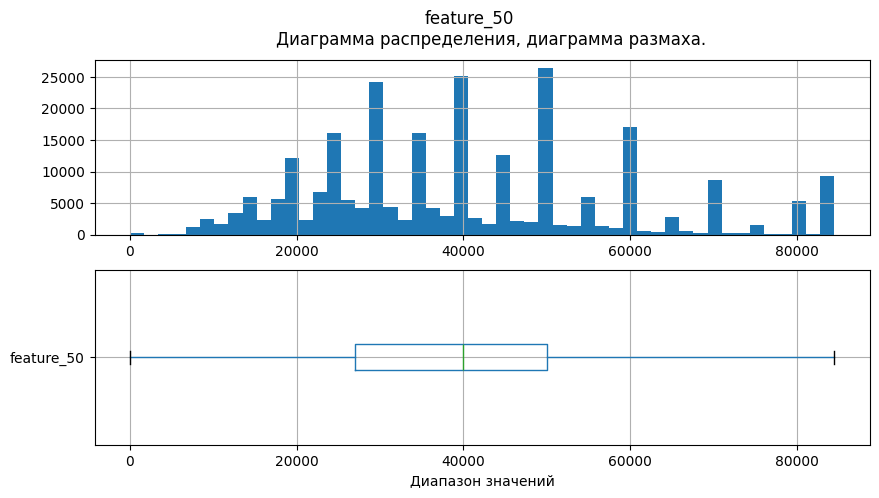

count    255820.000000
mean      40761.462438
std       18303.569079
min           0.000000
25%       27000.000000
50%       40000.000000
75%       50000.000000
max       84500.000000
Name: feature_50, dtype: float64

Уникальных значений: 1046
Выбросы: отсутствуют


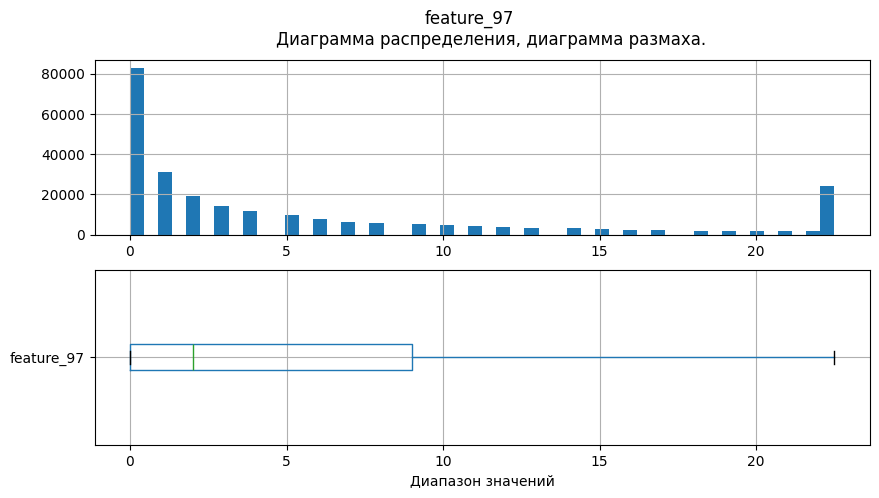

count    255820.000000
mean          5.780762
std           7.441265
min           0.000000
25%           0.000000
50%           2.000000
75%           9.000000
max          22.500000
Name: feature_97, dtype: float64

Уникальных значений: 24
Выбросы: отсутствуют


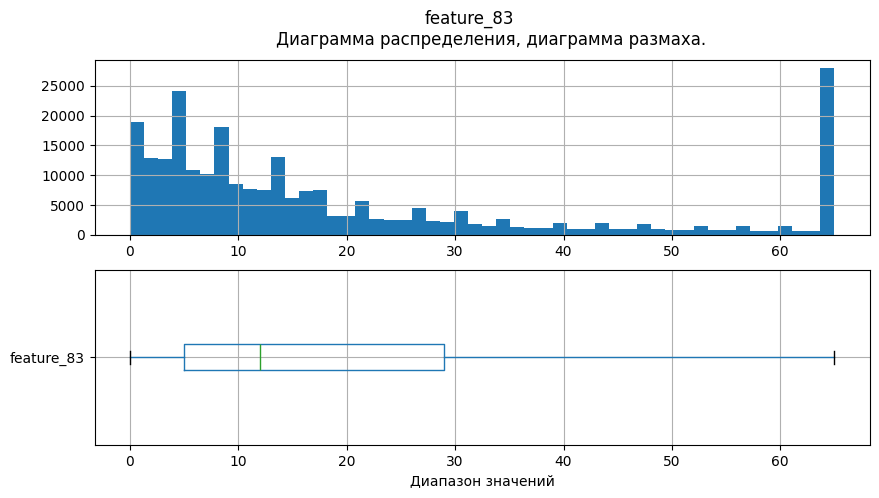

count    255820.000000
mean         20.395075
std          20.611932
min           0.000000
25%           5.000000
50%          12.000000
75%          29.000000
max          65.000000
Name: feature_83, dtype: float64

Уникальных значений: 66
Выбросы: 10.51%


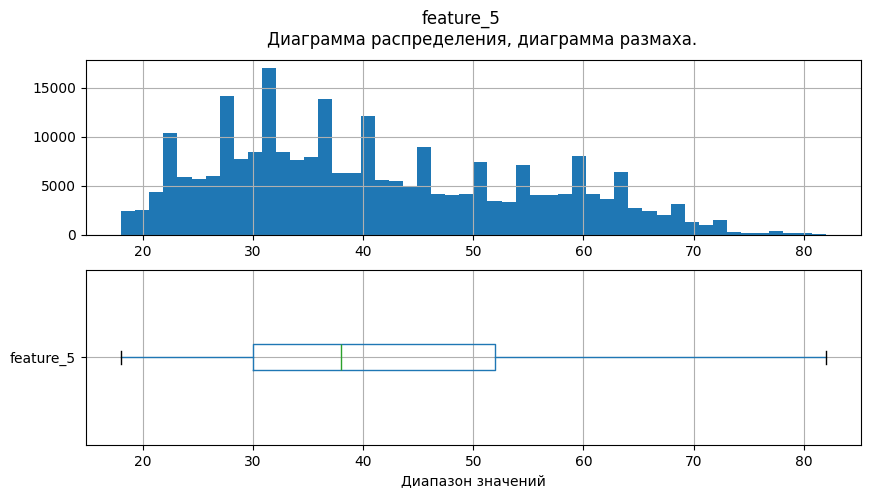

count    255820.000000
mean         41.053213
std          13.754019
min          18.000000
25%          30.000000
50%          38.000000
75%          52.000000
max          82.000000
Name: feature_5, dtype: float64

Уникальных значений: 65
Выбросы: отсутствуют


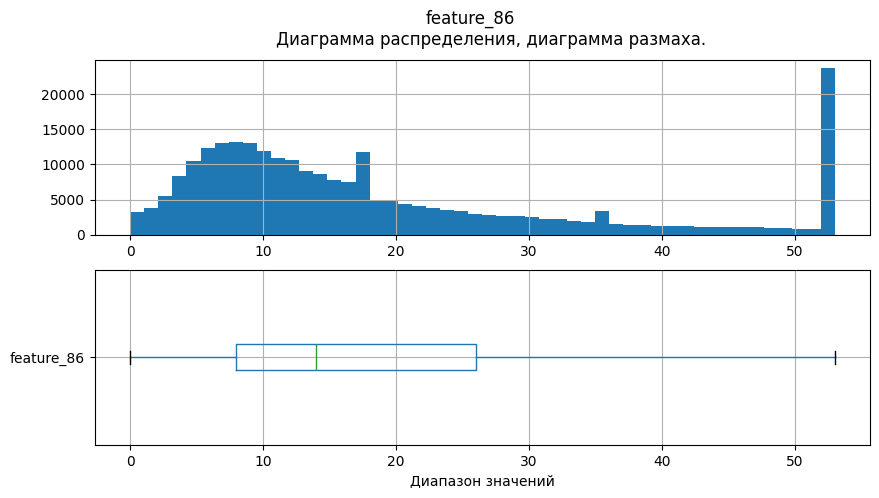

count    255820.000000
mean         19.289352
std          15.167183
min           0.000000
25%           8.000000
50%          14.000000
75%          26.000000
max          53.000000
Name: feature_86, dtype: float64

Уникальных значений: 54
Выбросы: отсутствуют


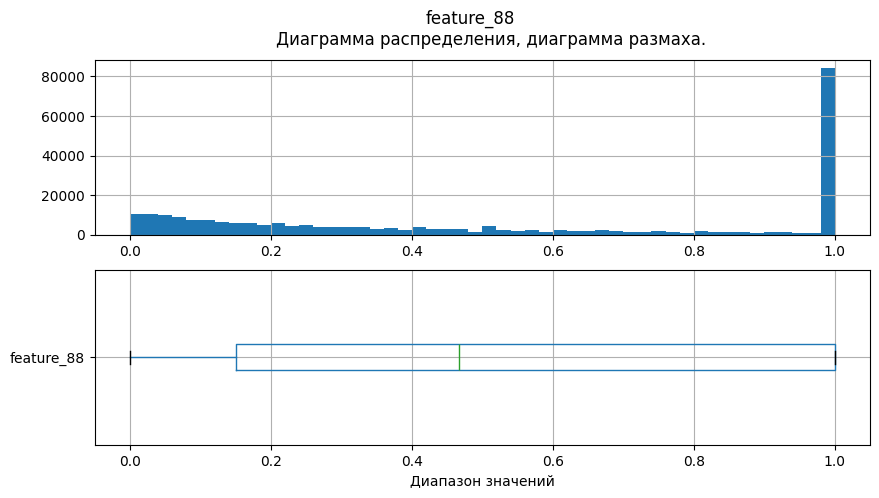

count    255820.000000
mean          0.534262
std           0.388521
min           0.000000
25%           0.150000
50%           0.466667
75%           1.000000
max           1.000000
Name: feature_88, dtype: float64

Уникальных значений: 12206
Выбросы: отсутствуют


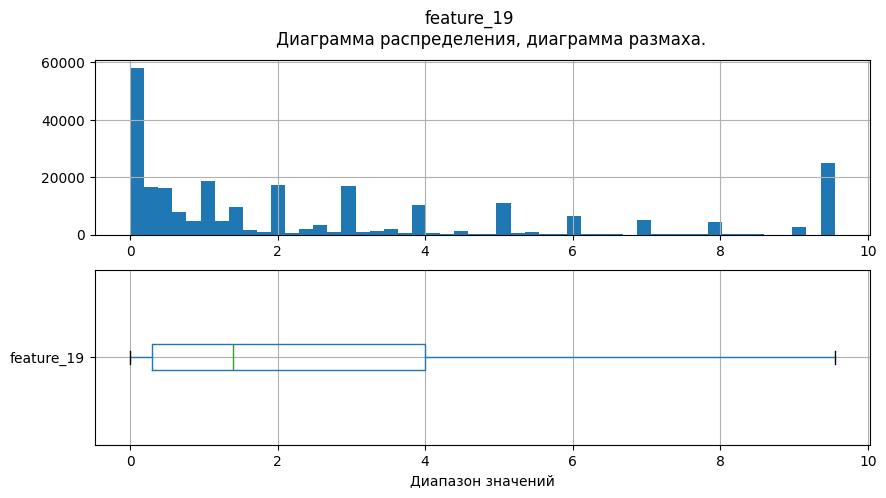

count    255820.000000
mean          2.685661
std           3.092182
min           0.000000
25%           0.300000
50%           1.400000
75%           4.000000
max           9.550000
Name: feature_19, dtype: float64

Уникальных значений: 97
Выбросы: отсутствуют


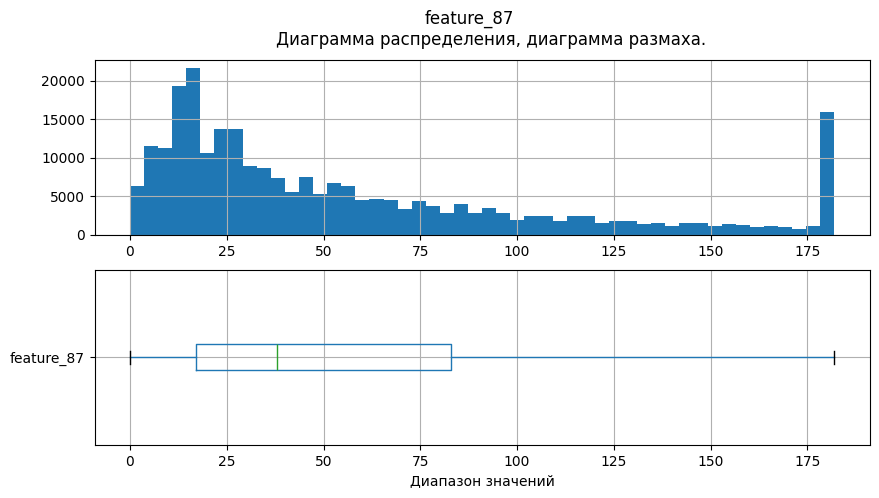

count    255820.000000
mean         57.420456
std          51.872860
min           0.000000
25%          17.000000
50%          38.000000
75%          83.000000
max         182.000000
Name: feature_87, dtype: float64

Уникальных значений: 183
Выбросы: отсутствуют


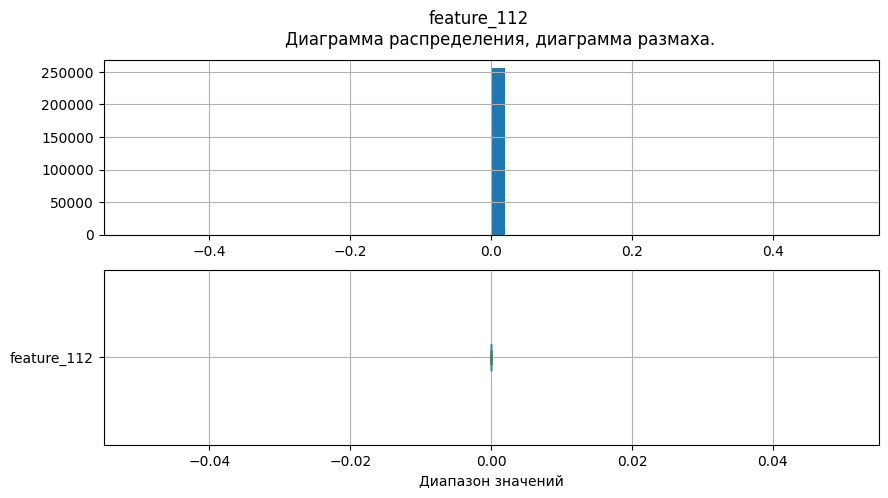

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_112, dtype: float64

Уникальных значений: 1
Выбросы: 22.77%


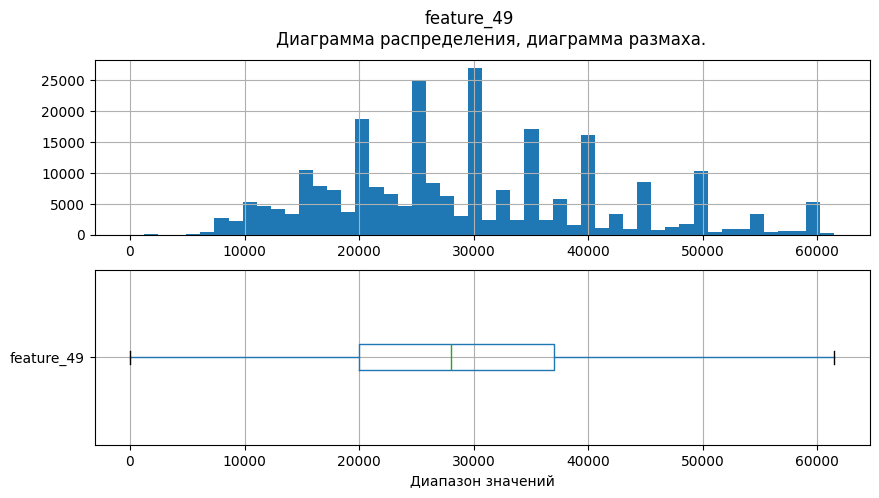

count    255820.000000
mean      29409.935494
std       12102.403580
min           0.000000
25%       20000.000000
50%       28000.000000
75%       37000.000000
max       61500.000000
Name: feature_49, dtype: float64

Уникальных значений: 1304
Выбросы: отсутствуют


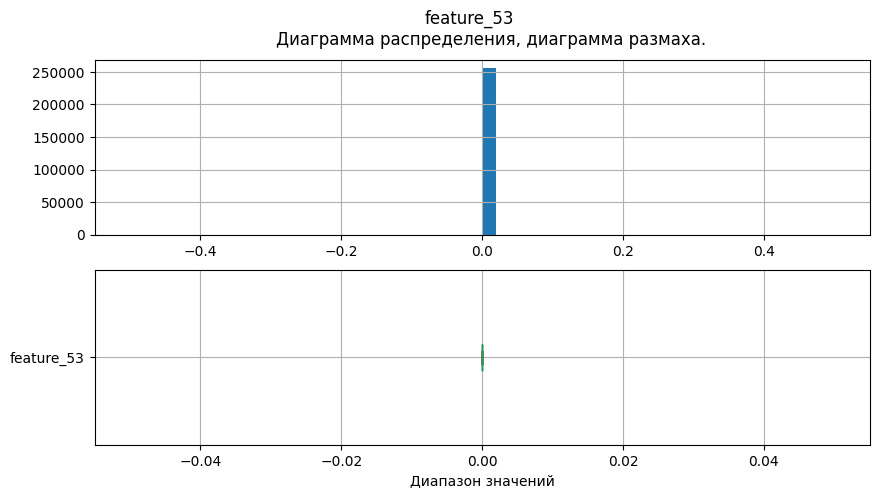

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_53, dtype: float64

Уникальных значений: 1
Выбросы: отсутствуют


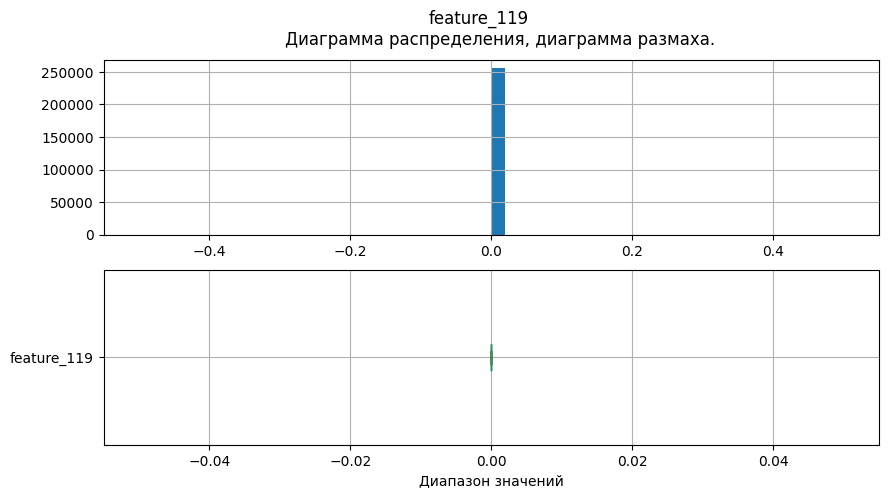

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_119, dtype: float64

Уникальных значений: 1
Выбросы: отсутствуют


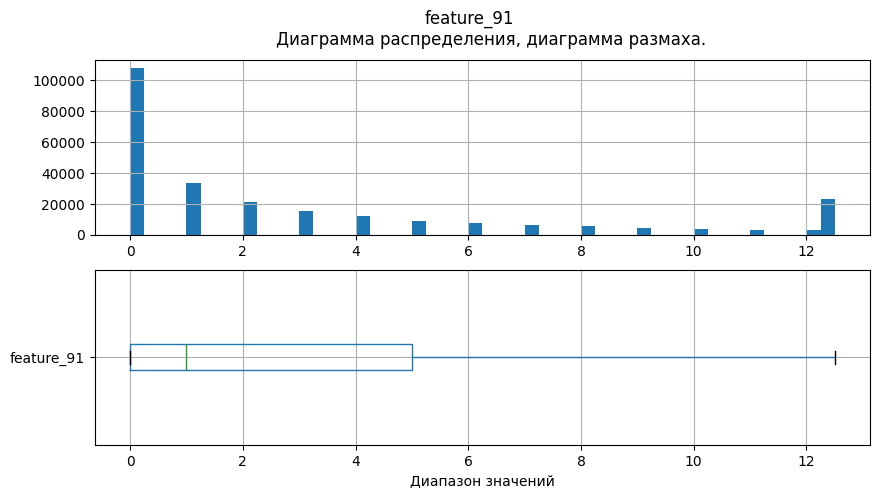

count    255820.000000
mean          3.076065
std           4.135432
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max          12.500000
Name: feature_91, dtype: float64

Уникальных значений: 14
Выбросы: отсутствуют


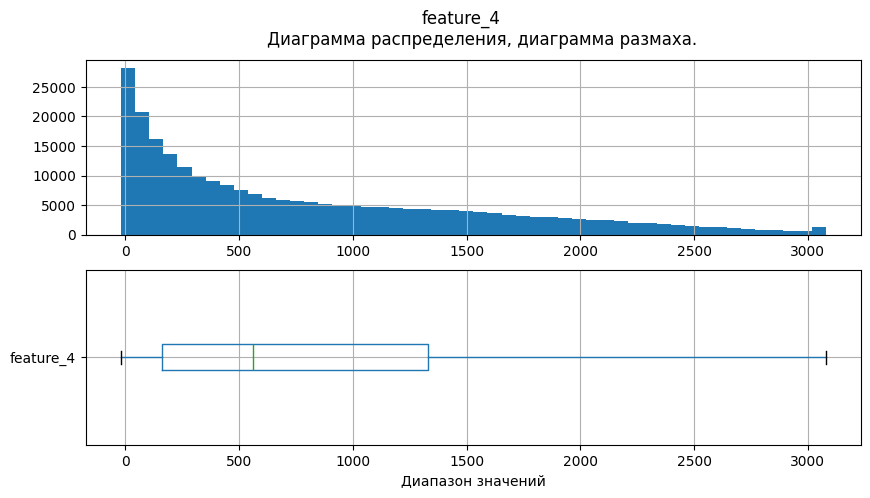

count    255820.000000
mean        819.017618
std         771.641781
min         -18.000000
25%         163.000000
50%         562.000000
75%        1329.000000
max        3078.000000
Name: feature_4, dtype: float64

Уникальных значений: 3080
Выбросы: отсутствуют


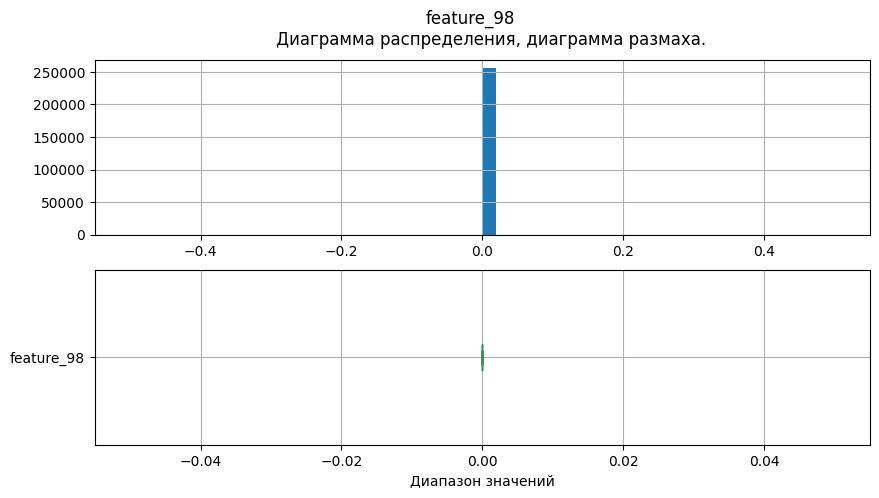

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_98, dtype: float64

Уникальных значений: 1
Выбросы: отсутствуют


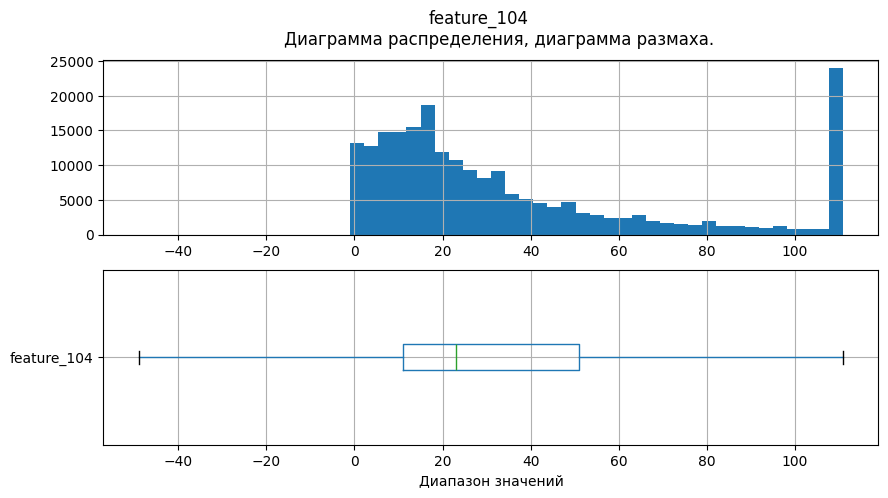

count    218025.000000
mean         36.556115
std          34.388310
min         -49.000000
25%          11.000000
50%          23.000000
75%          51.000000
max         111.000000
Name: feature_104, dtype: float64

Уникальных значений: 147
Выбросы: 10.56%


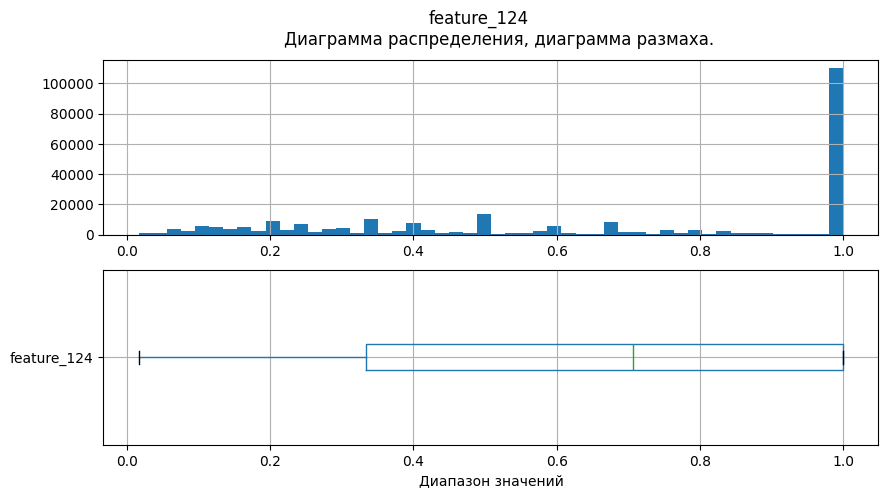

count    255820.000000
mean          0.659698
std           0.343397
min           0.016667
25%           0.333333
50%           0.705882
75%           1.000000
max           1.000000
Name: feature_124, dtype: float64

Уникальных значений: 1980
Выбросы: отсутствуют


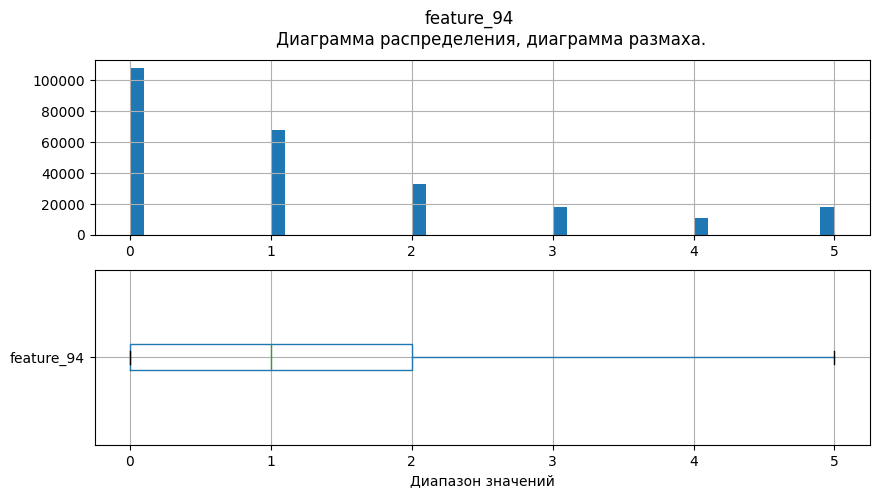

count    255820.000000
mean          1.254812
std           1.506936
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: feature_94, dtype: float64

Уникальных значений: 6
Выбросы: отсутствуют


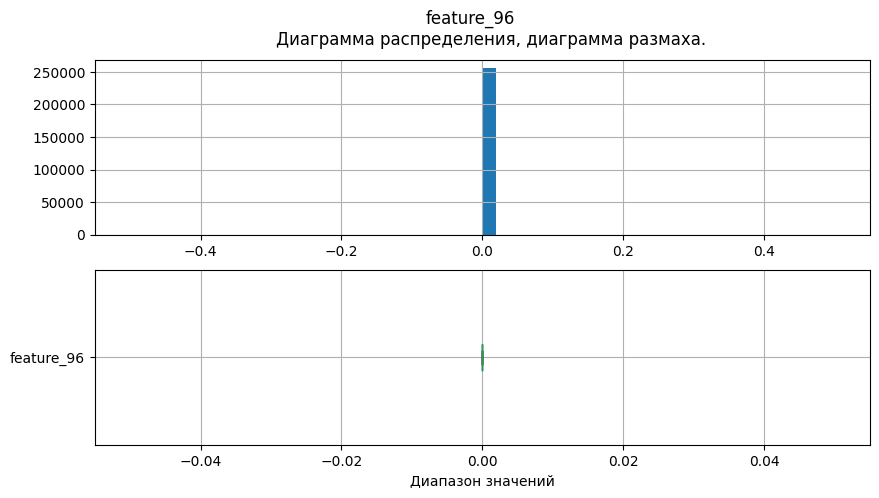

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_96, dtype: float64

Уникальных значений: 1
Выбросы: 22.3%


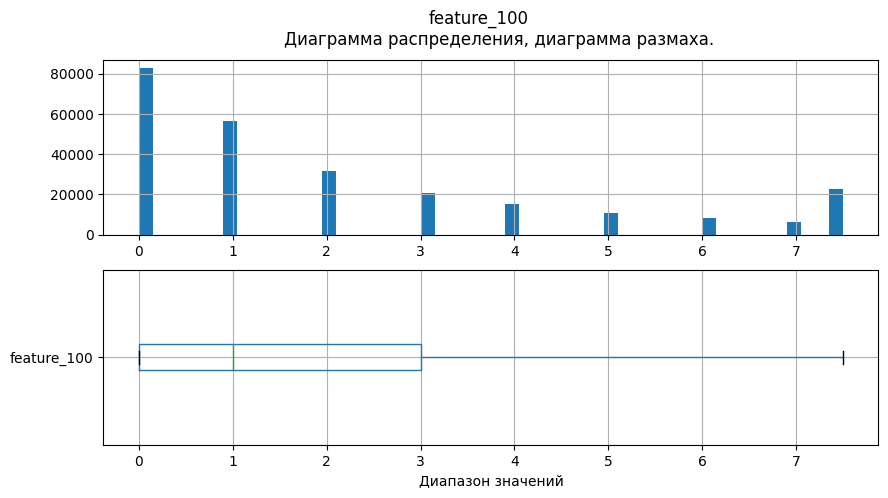

count    255820.000000
mean          2.204912
std           2.452831
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           7.500000
Name: feature_100, dtype: float64

Уникальных значений: 9
Выбросы: отсутствуют


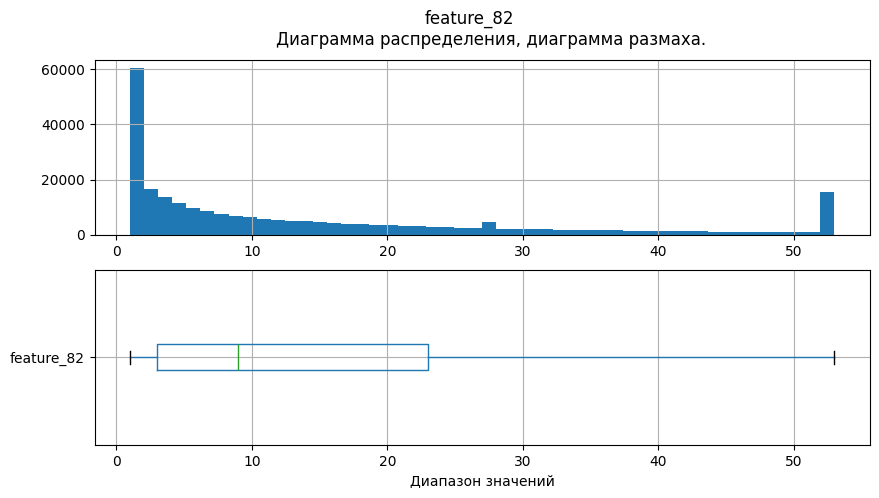

count    255820.000000
mean         14.950610
std          15.590704
min           1.000000
25%           3.000000
50%           9.000000
75%          23.000000
max          53.000000
Name: feature_82, dtype: float64

Уникальных значений: 53
Выбросы: отсутствуют


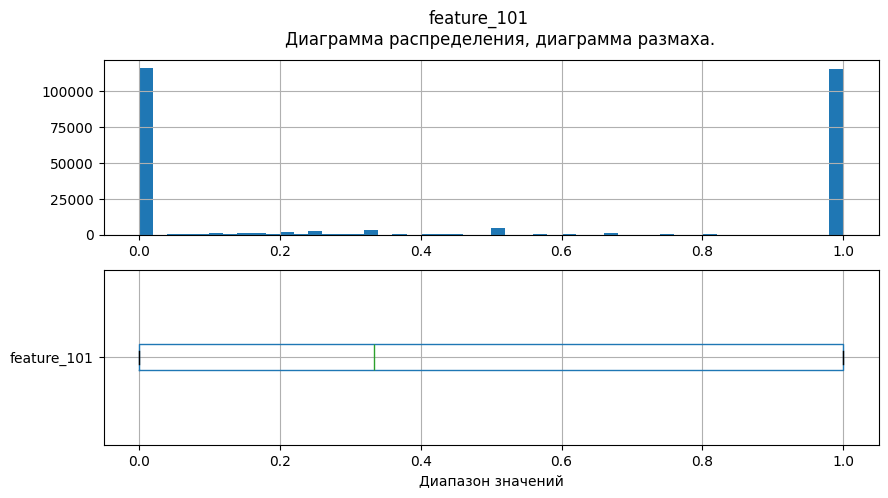

count    255820.000000
mean          0.485240
std           0.481404
min           0.000000
25%           0.000000
50%           0.333333
75%           1.000000
max           1.000000
Name: feature_101, dtype: float64

Уникальных значений: 280
Выбросы: отсутствуют


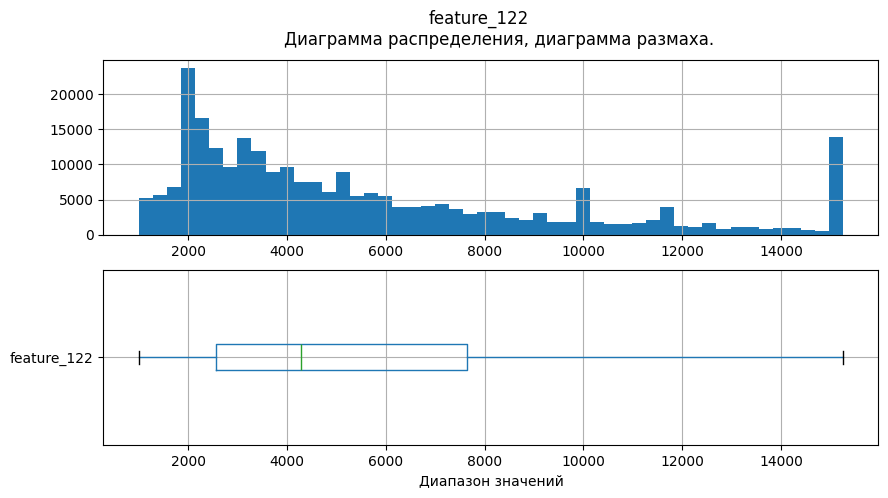

count    255820.000000
mean       5627.552357
std        3893.238824
min        1000.000000
25%        2559.024050
50%        4277.777700
75%        7638.338725
max       15257.310737
Name: feature_122, dtype: float64

Уникальных значений: 30910
Выбросы: отсутствуют


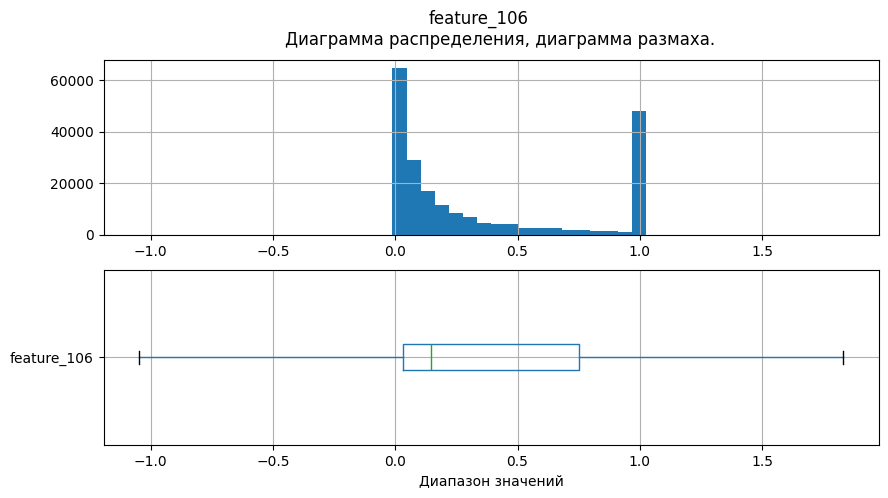

count    213927.000000
mean          0.354828
std           0.395285
min          -1.049166
25%           0.031646
50%           0.146341
75%           0.752187
max           1.832999
Name: feature_106, dtype: float64

Уникальных значений: 29876
Выбросы: отсутствуют


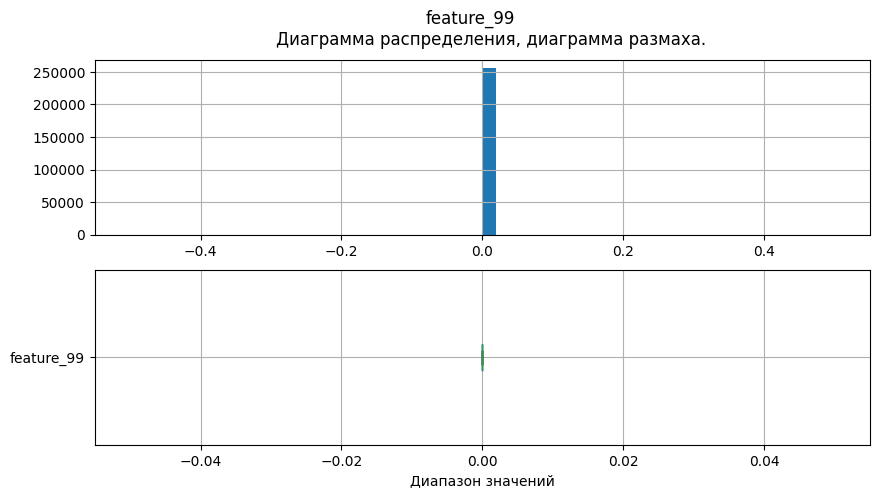

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_99, dtype: float64

Уникальных значений: 1
Выбросы: 19.75%


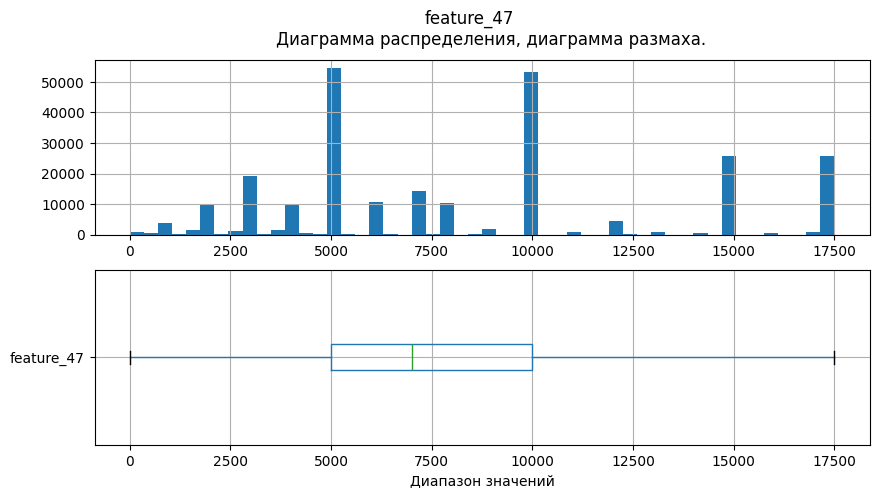

count    255820.000000
mean       8428.792549
std        4825.769693
min           0.000000
25%        5000.000000
50%        7000.000000
75%       10000.000000
max       17500.000000
Name: feature_47, dtype: float64

Уникальных значений: 201
Выбросы: 10.03%


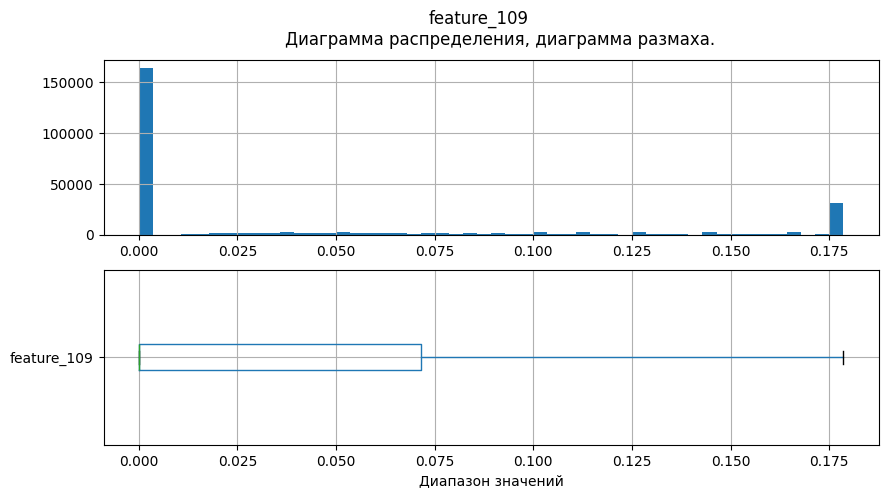

count    255820.000000
mean          0.041260
std           0.065152
min           0.000000
25%           0.000000
50%           0.000000
75%           0.071429
max           0.178571
Name: feature_109, dtype: float64

Уникальных значений: 475
Выбросы: 12.14%


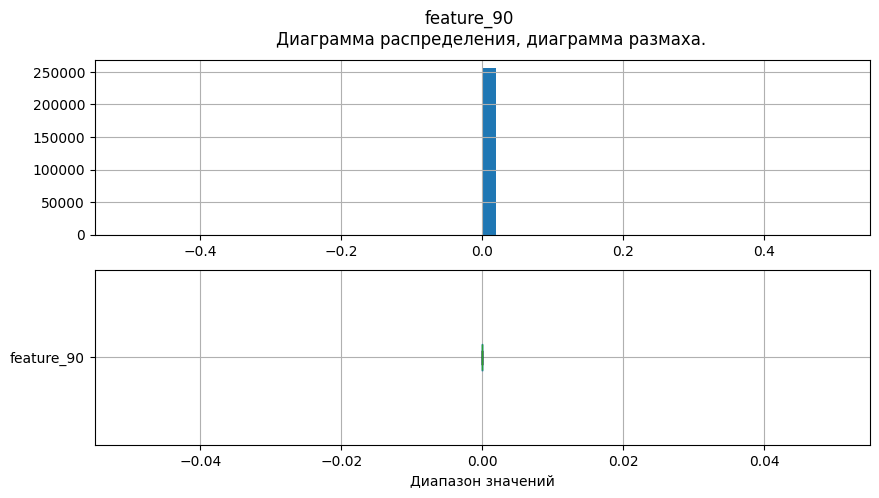

count    255820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: feature_90, dtype: float64

Уникальных значений: 1
Выбросы: 24.68%


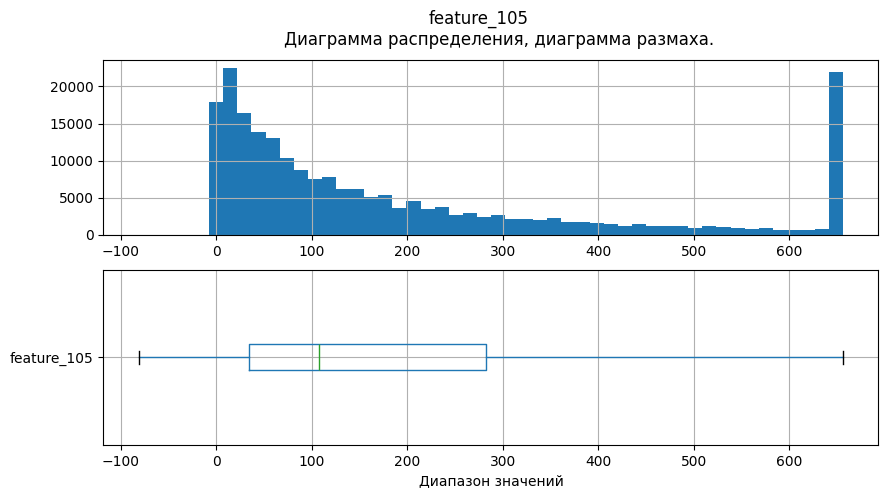

count    218025.000000
mean        193.568616
std         208.714559
min         -81.000000
25%          34.000000
50%         108.000000
75%         283.000000
max         656.500000
Name: feature_105, dtype: float64

Уникальных значений: 660
Выбросы: отсутствуют


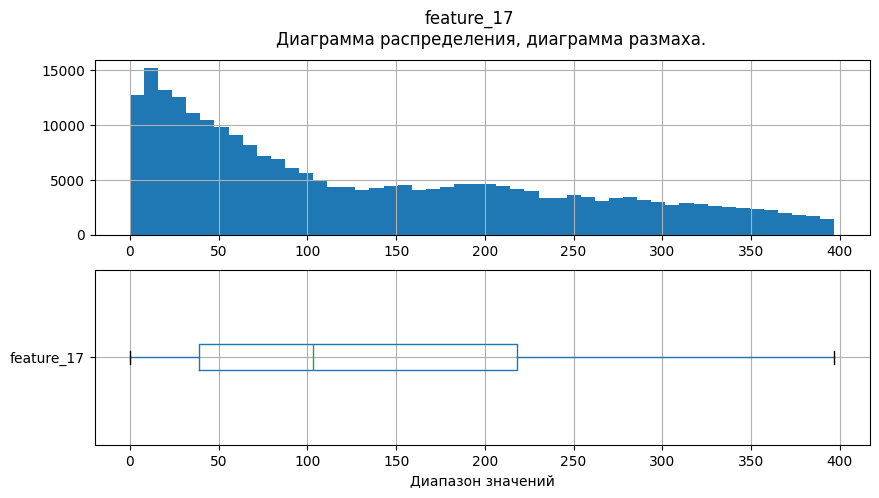

count    255820.000000
mean        135.139758
std         110.063157
min           0.000000
25%          39.000000
50%         103.000000
75%         218.000000
max         397.000000
Name: feature_17, dtype: float64

Уникальных значений: 398
Выбросы: отсутствуют


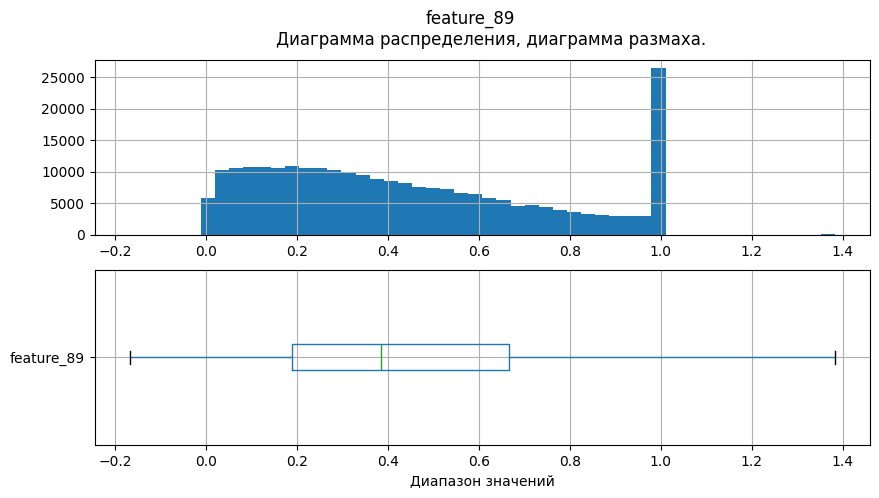

count    255820.000000
mean          0.445121
std           0.306171
min          -0.166667
25%           0.188459
50%           0.385691
75%           0.665901
max           1.382065
Name: feature_89, dtype: float64

Уникальных значений: 135993
Выбросы: отсутствуют


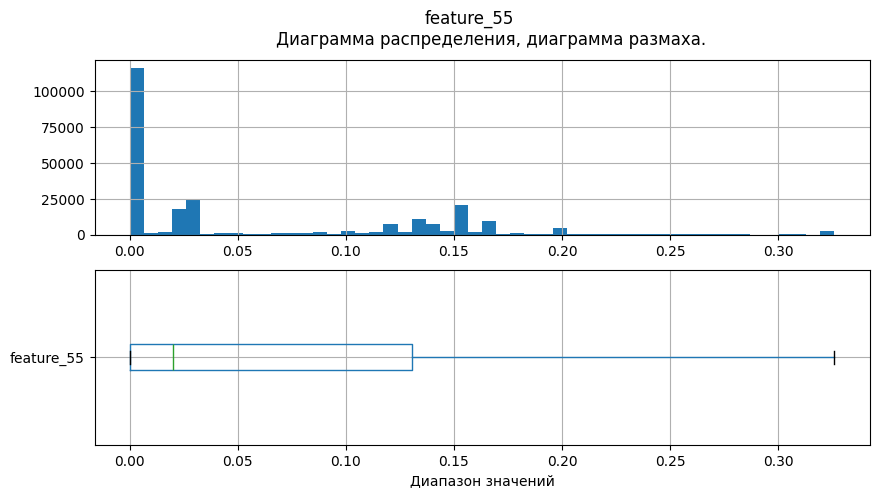

count    255820.000000
mean          0.059855
std           0.076926
min           0.000000
25%           0.000000
50%           0.020000
75%           0.130434
max           0.326085
Name: feature_55, dtype: float64

Уникальных значений: 4832
Выбросы: отсутствуют


In [28]:
# Построим боксплоты и гистограммы для признаков quantitative_columns
if FULL_CALC:
    for key in quantitative_columns:
        plot_hist_boxplot(df=data_reduced, 
                          column=key,
                          title=f'{key}\n\
        Диаграмма распределения, диаграмма размаха.',
                          xlabel='Диапазон значений')

После обработки выбросов признаки 53, 90, 96, 98, 99, 112, 119 имеют только одно уникальное значение. Для дальнейшего анализа удалим эти признаки.

In [29]:
# Удалим признаки
columns_to_drop = ['feature_53', 'feature_90', 'feature_96', 'feature_98', 'feature_99', 'feature_112', 'feature_119']
data_reduced = data_reduced.drop(columns=columns_to_drop)

**Итог:**

После обработки выбросов признаки 53, 90, 96, 98, 99, 112, 119 имеют только одно уникальное значение. Эти признаки исключили из выборки. 
<br> В дальнейшем, в качестве эксперимента, можно сделать эти признаки категориальными: вывести выбросы вверх и выбросы вниз в отдельные классы.

**Вывод**

Исследовательский анализ завершен.
- Дубликатов не обнаружено.
- Были обнаружены коррелированные признаки. Такие признаки исключены из выборки.
- Были обнаружены выбросы. Произведена их обработка.

В дальнейшем, при получении информации о признаках, целесообразно провести более детальный исследовательский анализ.

## Подготовка даных и обучение модели

- Разделим выборку data_reduced на обучающую и тестовую.
- В пайплайне заполним пропущенные значения и стандартизируем данные.
- Обучим модель логистической регресиии.

In [30]:
# Выделим входные и целевой признаки
X = data_reduced.drop(columns=['target'])
y = data_reduced['target']

In [31]:
# выведем входные признаки (перввые строки)
X.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_106,feature_107,feature_108,feature_109,feature_114,feature_115,feature_116,feature_122,feature_123,feature_124
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1381,63,0,0,1,0,0,...,0.610000,0,2.5,0.178571,0,0,0,7526.3157,12000,0.583333
2,0,0,0,1809,33,1,0,1,0,0,...,0.000000,1,2.5,0.081967,0,0,0,8393.4426,30000,0.333333
3,0,0,0,1804,29,0,1,0,0,0,...,0.139130,0,2.5,0.055556,0,1,0,3425.9259,15000,0.200000
4,0,0,0,1560,28,1,1,0,0,0,...,0.043103,0,0.0,0.000000,0,0,0,1946.6666,3000,0.666667
5,0,0,0,258,33,1,0,0,0,1,...,0.071429,0,0.0,0.000000,0,0,0,4444.4444,8000,0.250000


In [32]:
# выведем целевой признак (перввые строки)
y.head()

ID
1    0
2    0
3    0
4    0
5    0
Name: target, dtype: int64

In [33]:
# Разделение данных на обучающие и тестовые со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [34]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (191865, 102)
y_train: (191865,)
X_test: (63955, 102)
y_test: (63955,)


In [35]:
%%time
# Определяем пайплайн для обработки признаков и модели
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),  # Заполнение пропущенных значений
    StandardScaler(), # Стандартизация данных
    LogisticRegression(max_iter=100,     
                       solver='liblinear', # для двух классов
                       class_weight='balanced', # автоматическая настройка весов классов
                       random_state=RANDOM_STATE,
                       )  
)
pipeline.fit(X_train, y_train);

CPU times: total: 19.2 s
Wall time: 19.5 s


**Вывод:**
- Выборка data_reduced разделена на обучающую и тестовую.
- В пайплайне заполнены пропуски и стандартизированы данные.
- Модель логистической регрессии обучена, приступим к анализу результатов.

## Оценка результатов работы модели

- Получим предсказания модели для тестовой выборки и вероятности положительного класса.
- Выведем основные метрики качества модели для тестовой выборки и проанализируем результаты.

### Метрики на тестовой выборке

In [36]:
# Предсказания модели на тестовой выборке
y_test_pred = pipeline.predict(X_test)

# Вероятности предсказаний модели на тестовой выборке
y_test_proba = pipeline.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

In [37]:
# Функция для вычисления и печати метрик 
def metrics(y_test, y_pred, y_proba):
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Коэффициент Джини
    gini_coefficient = 2 * roc_auc - 1
    
    # Печать метрик
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Gini Coefficient: {gini_coefficient:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # построим матрицу ошибок
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted'); 

ROC-AUC: 0.7757
Accuracy: 0.7055
Gini Coefficient: 0.5513
F1 Score: 0.4894
Precision: 0.3721
Recall: 0.7150


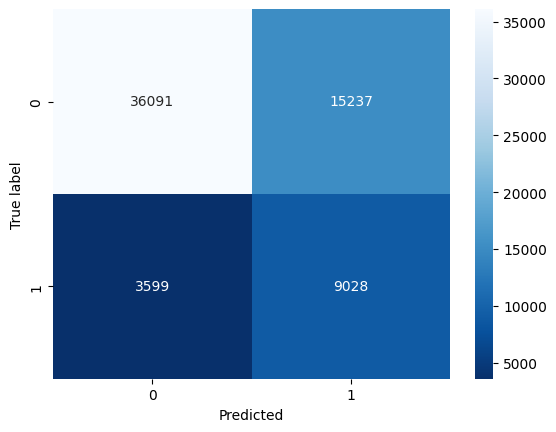

In [38]:
# Оценка модели на тестовой выборке
metrics(y_test, y_test_pred, y_test_proba)

**Вывод:**

- Величина ROC-AUC показывает, как хорошо модель различает положительный и отрицательный классы. Значение 0.7757 указывает на хорошую способность модели различать классы.
- Точность (Accuracy) модели составляет 70.55%, что означает, что модель правильно классифицирует примерно 71% всех примеров.
- Коэффициент Джини (Gini Coefficient) равен 0.5513, что указывает на среднюю способность модели при различении (дискриминации) положительных и отрицательных классов. Модель лучше случайного угадывания, но остается место для улучшения точности и надежности предсказаний.
- F1-мера составляет 0.4894, что указывает на компромисс между точностью (Precision) и полнотой (Recall). Это значение говорит о сбалансированности модели.
- Точность (Precision) составляет 0.3721, что означает, что из всех предсказанных моделью положительных классов, только 37.21% действительно являются положительными.
- Полнота (Recall) равна 0.7150, что указывает на долю действительных положительных примеров, которые модель правильно предсказала. Значение 71.50% означает, что модель обнаруживает большую часть реальных положительных примеров.

Заключение:

Модель показывает хорошую способность к классификации, особенно в плане дискриминации положительных и отрицательных классов (ROC-AUC и коэффициент Джини), и имеет достаточно высокую полноту. Однако, значение точности может указывать на высокий уровень ложноположительных срабатываний. В целом, модель сбалансирована по F1-мере, но есть возможность для улучшения точности.

### Группировка и оценка обучающей выборки

- Получим предсказания модели для обучающей выборки и вероятности положительного класса.
- Сгруппируем обучающую выборку по значениям вероятности с шагом 0.1, и в каждой группе посчитаем сколичество объектов с target = 1.

In [39]:
# Предсказания модели на обучающей выборке
y_train_pred = pipeline.predict(X_train)

# Вероятности предсказаний модели на обучающей выборке
y_train_proba = pipeline.predict_proba(X_train)[:, 1]  # Вероятности положительного класса

In [40]:
# Создадим датафрейм для результатов обучающей выборки
train_results = pd.DataFrame({
    'probability': y_train_proba,
    'target': y_train
})

# Создадим группу вероятностей с шагом 0.1
train_results['prob_group'] = pd.cut(train_results['probability'], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
train_results

,probability,target,prob_group
ID,,,
40235,0.621704,0,"(0.6, 0.7]"
5365,0.182305,0,"(0.1, 0.2]"
63481,0.417670,0,"(0.4, 0.5]"
120410,0.275559,0,"(0.2, 0.3]"
61064,0.236917,0,"(0.2, 0.3]"
...,...,...,...
53105,0.428877,0,"(0.4, 0.5]"
185165,0.601812,0,"(0.6, 0.7]"
178670,0.464259,0,"(0.4, 0.5]"


In [41]:
# Группировка по интервалам вероятностей
grouped_results = train_results.groupby('prob_group').agg(
    count=('probability', 'size'),
    count_target_1=('target', 'sum')
).reset_index()

print('Группировка вероятностей:')
print(grouped_results)

Группировка вероятностей:
      prob_group  count  count_target_1
0  (-0.001, 0.1]   5767              88
1     (0.1, 0.2]  32637            1171
2     (0.2, 0.3]  31423            2229
3     (0.3, 0.4]  27093            3296
4     (0.4, 0.5]  22522            3995
5     (0.5, 0.6]  20805            5201
6     (0.6, 0.7]  20840            6763
7     (0.7, 0.8]  17199            7403
8     (0.8, 0.9]   9430            4979
9     (0.9, 1.0]   4149            2758


**Вывод:**

**1. Качество прогнозов**:
- В нижней границе вероятностей [0.0−0.1] процент правильных предсказаний (целевой класс = 1) составляет около 1.5% (88 из 5767). Это показывает, что вероятность предсказания положительного класса по этому интервалу крайне мала.
- В самых уверенных предсказаниях (0.9−1.0] процент правильных предсказаний составляет около 66.5% (2758 из 4149), что является значительным улучшением по сравнению с нижней границей, указывая на высокую точность при высокой уверенности модели.

**2. Общее поведение модели**:
- Модель имеет тенденцию предсказывать положительный класс (целевой класс = 1) с большей уверенностью, когда вероятность выше, что свидетельствует о её способности различать классы с разной степенью уверенности.
- Модель не предпочитает оставаться близкой к параметру случайности (при вероятности около 0.5).

**3. Производительность модели**:
- Наибольшая концентрация верных предсказаний приходится на промежуток (0.6, 0.7] и выше, что показывает важность обучения модели для точных прогнозов и возможности дальнейшего улучшения для меньших вероятностей.

Таким образом, модель демонстрирует ожидаемое поведение классификации, где вероятность положительного предсказания увеличивается с ростом уверенности модели. Эти данные можно использовать для дальнейшего улучшения и настройки модели.

## Подготовка данных и получение прогнозов

- Подготовим данные датафрейма `verify`, получим предсказания и запишем в файл `predictions.csv`.

In [42]:
# Создадим датафрейм verify_reduced на основе verify. Удалим коррелированные признаки.
verify_reduced = verify.drop(columns=removed_columns)
verify_reduced.shape

(56030, 109)

In [43]:
# каппируем выбросы во всех столбцах quantitative_columns
verify_reduced = winsorize(verify_reduced, quantitative_columns)

In [44]:
# Удалим признаки, выбывшие в результате анализа выбросов.
verify_reduced = verify_reduced.drop(columns=columns_to_drop)
verify_reduced.shape

(56030, 102)

In [45]:
# вычислим вероятности принадлежности классам
verify_reduced['score'] = pipeline.predict_proba(verify_reduced)[:, 1]
verify_reduced

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_107,feature_108,feature_109,feature_114,feature_115,feature_116,feature_122,feature_123,feature_124,score
ID,,,,,,,,,,,,,,,,,,,,,
255821,0,0,0,2268,34,0,1,0,0,0,...,0,2.0,0.040816,0,1,0,4551.0204,12000,0.500000,0.132263
255822,0,0,0,42,49,0,0,1,0,0,...,0,0.0,0.000000,0,0,0,4700.0000,6000,1.000000,0.607156
255823,0,0,0,265,69,0,1,0,0,0,...,0,0.0,0.000000,0,0,0,4133.3333,6000,0.500000,0.818817
255824,1,0,0,834,25,1,0,1,0,0,...,0,1.0,0.031250,0,0,0,3875.0000,11000,0.181818,0.104961
255825,0,0,0,772,26,1,1,0,0,0,...,0,0.0,0.000000,0,1,0,7640.0000,12000,0.666667,0.526925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311846,0,0,0,58,27,0,0,1,0,0,...,0,0.0,0.000000,0,0,0,3100.0000,4000,0.750000,0.452413
311847,1,0,0,131,28,0,0,1,0,0,...,0,0.0,0.000000,0,0,0,8137.5000,12000,1.000000,0.250609
311848,0,0,0,199,32,0,0,1,0,0,...,0,2.0,0.178571,0,0,0,16745.5880,36200,0.828729,0.120370


In [46]:
# Проверим данные перед записью в файл
verify_reduced['score']

ID
255821    0.132263
255822    0.607156
255823    0.818817
255824    0.104961
255825    0.526925
            ...   
311846    0.452413
311847    0.250609
311848    0.120370
311849    0.418667
311850    0.501065
Name: score, Length: 56030, dtype: float64

In [47]:
# Сохранение результатов
verify_reduced['score'].to_csv('predictions.csv', sep=';', index=True)

**Итог:**
- Подготовили выборку `verify` и определили вероятность принадлежности к таргет 1 каждого объекта.
- Результаты записали в файл `predictions.csv`

## Выводы

**В ходе проекта провели следующую работу:**

- Изучили данные, проверили их на предмет аномалий и несоответствий.
- Провели исследовательский анализ.
- Произвели предобработку данных.
- Обучили модель логистической регрессии для решения задачи двухклассовой классификации.
- Посчитали метрики модели и оценили качество предсказаний на тестовой выборке.
- Получили вероятности принадлежности к классам для тренировочной выборки. Сгруппировали выборку по значениям вероятности с шагом 0.1, и в каждой группе посчитали количество объектов с target = 1.
- С помощью полученной модели определили вероятность принадлежности к таргет 1 каждого объекта из `verify.csv`. Записали полученные предсказания в `predictions.csv`.

**Результаты:**

Метрики модели LogisticRegression:

- ROC-AUC: 0.7757
- Accuracy: 0.7055
- Gini Coefficient: 0.5513
- F1 Score: 0.4894
- Precision: 0.3721
- Recall: 0.7150

Модель показывает хорошую способность к классификации, особенно в плане дискриминации положительных и отрицательных классов (ROC-AUC и коэффициент Джини), и имеет достаточно высокую полноту. Однако, значение точности может указывать на высокий уровень ложноположительных срабатываний. В целом, модель сбалансирована по F1-мере, но есть возможность для улучшения точности.

**Рекомендации:**

Модель можно улучшить, проведя следующую работу:

- Учитывая информацию о признаках, более детально обработать выбросы. Сгруппировать данные в некоторых признаках для выделения категорий.
- Создать полиномиальные признаки. Так как признаков уже довольно много, важно не перегрузить модель новыми признаками. Лучше использовать самописные функции для анализа и точечного добавления новых признаков, чем стандартные средства, такие как PolynomialFeatures.
- Провести анализ признаков и исключить лишние, например, при помощи библиотеки SHAP.
- Провести эксперименты с различными гиперпараметрами и методами предобработки данных для модели LogisticRegression.
- Провести эксперименты с несколькими моделями и использовать методы автоматического подбора гиперпараметров, такие как сеточный поиск (GridSearchCV) или случайный поиск (RandomizedSearchCV), чтобы выбрать наиболее подходящую модель.